<a href="https://colab.research.google.com/github/mishra-bytes/Face-Orientation-Detector/blob/main/MediaPipe_FaceMesh-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip uninstall -y mediapipe
!pip install -q mediapipe==0.10.31


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions

IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5
GENERAL_EXPAND = 20


FACE_LANDMARKER_MODEL = "face_landmarker.task"

if not os.path.exists(FACE_LANDMARKER_MODEL):
    !wget -q -O face_landmarker.task \
    https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task


if not os.path.exists("deploy.prototxt"):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

if not os.path.exists("res10_300x300_ssd_iter_140000.caffemodel"):
    !wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


# MediaPipe FaceLandmarker
face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=FACE_LANDMARKER_MODEL),
        num_faces=1
    )
)

# OpenCV DNN SSD
dnn_net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)

# Haar Cascade
haar = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


image_files = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(image_files, NUM_SAMPLES)


for idx, img_path in enumerate(samples, 1):
    print(f"\n[{idx}/{NUM_SAMPLES}] {img_path}")

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)


    # FaceLandmarker (Hull Mask)

    lm_result = face_landmarker.detect(mp_image)
    mask_lm = np.zeros((h, w), dtype=np.uint8)

    if lm_result.face_landmarks:
        pts = np.array(
            [[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]],
            dtype=np.int32
        )
        hull = cv2.convexHull(pts)
        cv2.fillConvexPoly(mask_lm, hull, 255)
        mask_lm = cv2.dilate(
            mask_lm,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (GENERAL_EXPAND, GENERAL_EXPAND))
        )

    out_lm = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)


    # OpenCV DNN SSD

    blob = cv2.dnn.blobFromImage(
        img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0)
    )
    dnn_net.setInput(blob)
    detections = dnn_net.forward()

    mask_dnn = np.zeros((h, w), dtype=np.uint8)
    if detections.shape[2] > 0:
        conf = detections[0, 0, 0, 2]
        if conf > 0.5:
            box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            mask_dnn[y1:y2, x1:x2] = 255

    out_dnn = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)


    # Haar Cascade

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    mask_haar = np.zeros((h, w), dtype=np.uint8)

    if len(faces):
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y + fh, x:x + fw] = 255

    out_haar = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)


    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("MediaPipe FaceLandmarker")
    plt.imshow(out_lm)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("OpenCV DNN SSD")
    plt.imshow(out_dnn)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Haar Cascade")
    plt.imshow(out_haar)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions


IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5

GENERAL_EXPAND = 20
DNN_PADDING_RATIO = 0.05


FACE_LANDMARKER_MODEL = "face_landmarker.task"

if not os.path.exists(FACE_LANDMARKER_MODEL):
    !wget -q -O face_landmarker.task \
    https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

if not os.path.exists("deploy.prototxt"):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

if not os.path.exists("res10_300x300_ssd_iter_140000.caffemodel"):
    !wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=FACE_LANDMARKER_MODEL),
        num_faces=1
    )
)

dnn_net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)

haar = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


image_files = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(image_files, NUM_SAMPLES)


for idx, img_path in enumerate(samples, 1):
    print(f"\n[{idx}/{NUM_SAMPLES}] {img_path}")

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)


    lm_result = face_landmarker.detect(mp_image)
    mask_lm = np.zeros((h, w), dtype=np.uint8)

    if lm_result.face_landmarks:
        pts = np.array(
            [[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]],
            dtype=np.int32
        )
        hull = cv2.convexHull(pts)
        cv2.fillConvexPoly(mask_lm, hull, 255)
        mask_lm = cv2.dilate(
            mask_lm,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (GENERAL_EXPAND, GENERAL_EXPAND))
        )

    out_lm = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)


    blob = cv2.dnn.blobFromImage(
        img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0)
    )
    dnn_net.setInput(blob)
    detections = dnn_net.forward()

    mask_dnn = np.zeros((h, w), dtype=np.uint8)

    if detections.shape[2] > 0:
        conf = detections[0, 0, 0, 2]
        if conf > 0.5:
            x1, y1, x2, y2 = (
                detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
            ).astype(int)

            bw = x2 - x1
            bh = y2 - y1

            pad_w = int(bw * DNN_PADDING_RATIO)
            pad_h = int(bh * DNN_PADDING_RATIO)

            x1 = max(0, x1 - pad_w)
            y1 = max(0, y1 - pad_h)
            x2 = min(w, x2 + pad_w)
            y2 = min(h, y2 + pad_h)

            mask_dnn[y1:y2, x1:x2] = 255

    out_dnn = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)


    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    mask_haar = np.zeros((h, w), dtype=np.uint8)

    if len(faces):
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y + fh, x:x + fw] = 255

    out_haar = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("MediaPipe Landmarks")
    plt.imshow(out_lm)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title(f"OpenCV DNN (+{int(DNN_PADDING_RATIO*100)}% padding)")
    plt.imshow(out_dnn)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Haar Cascade")
    plt.imshow(out_haar)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import random
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions


IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5

GENERAL_EXPAND = 20
DNN_PADDING_RATIO = 0.05


FACE_LANDMARKER_MODEL = "face_landmarker.task"

if not os.path.exists(FACE_LANDMARKER_MODEL):
    !wget -q -O face_landmarker.task \
    https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task


if not os.path.exists("deploy.prototxt"):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

if not os.path.exists("res10_300x300_ssd_iter_140000.caffemodel"):
    !wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=FACE_LANDMARKER_MODEL),
        num_faces=1
    )
)

dnn_net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)

haar = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


image_files = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(image_files, NUM_SAMPLES)


for idx, img_path in enumerate(samples, 1):
    print(f"\n[{idx}/{NUM_SAMPLES}] {img_path}")

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)


    t0 = time.perf_counter()
    lm_result = face_landmarker.detect(mp_image)
    lm_time = (time.perf_counter() - t0) * 1000

    mask_lm = np.zeros((h, w), dtype=np.uint8)
    if lm_result.face_landmarks:
        pts = np.array(
            [[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]],
            dtype=np.int32
        )
        hull = cv2.convexHull(pts)
        cv2.fillConvexPoly(mask_lm, hull, 255)
        mask_lm = cv2.dilate(
            mask_lm,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (GENERAL_EXPAND, GENERAL_EXPAND))
        )

    out_lm = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)


    t0 = time.perf_counter()
    blob = cv2.dnn.blobFromImage(
        img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0)
    )
    dnn_net.setInput(blob)
    detections = dnn_net.forward()
    dnn_time = (time.perf_counter() - t0) * 1000

    mask_dnn = np.zeros((h, w), dtype=np.uint8)
    if detections.shape[2] > 0:
        conf = detections[0, 0, 0, 2]
        if conf > 0.5:
            x1, y1, x2, y2 = (
                detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
            ).astype(int)

            bw, bh = x2 - x1, y2 - y1
            pad_w, pad_h = int(bw * DNN_PADDING_RATIO), int(bh * DNN_PADDING_RATIO)

            x1 = max(0, x1 - pad_w)
            y1 = max(0, y1 - pad_h)
            x2 = min(w, x2 + pad_w)
            y2 = min(h, y2 + pad_h)

            mask_dnn[y1:y2, x1:x2] = 255

    out_dnn = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)

    t0 = time.perf_counter()
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    haar_time = (time.perf_counter() - t0) * 1000

    mask_haar = np.zeros((h, w), dtype=np.uint8)
    if len(faces):
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y + fh, x:x + fw] = 255

    out_haar = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)


    print(f"  FaceLandmarker : {lm_time:.2f} ms")
    print(f"  OpenCV DNN SSD : {dnn_time:.2f} ms")
    print(f"  Haar Cascade  : {haar_time:.2f} ms")


    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("MediaPipe Landmarks")
    plt.imshow(out_lm)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("OpenCV DNN (+ padding)")
    plt.imshow(out_dnn)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Haar Cascade")
    plt.imshow(out_haar)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# =========================================================
# INSTALL
# =========================================================
!pip install -q ultralytics opencv-python matplotlib numpy

# =========================================================
# IMPORTS
# =========================================================
import os
import random
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# =========================================================
# CONFIG
# =========================================================
IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5
PADDING = 0.30

# =========================================================
# LOAD VALID MODELS (ALL EXIST)
# =========================================================
yolo_detect = YOLO("yolov8n.pt")        # detection only
yolo_pose   = YOLO("yolov8n-pose.pt")  # keypoints
yolo_cls    = YOLO("yolov8n-cls.pt")   # classification backbone

# =========================================================
# LOAD IMAGES
# =========================================================
images = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

samples = random.sample(images, NUM_SAMPLES)

# =========================================================
# RUN TEST
# =========================================================
for i, path in enumerate(samples, 1):
    print(f"\n[{i}/{NUM_SAMPLES}] {path}")

    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # -----------------------------------------------------
    # 1️⃣ YOLOv8n Detection → padded mask
    # -----------------------------------------------------
    t0 = time.perf_counter()
    r_det = yolo_detect(img_rgb, conf=0.4, verbose=False)[0]
    t_det = (time.perf_counter() - t0) * 1000

    mask_det = np.zeros((h, w), dtype=np.uint8)
    if r_det.boxes is not None and len(r_det.boxes) > 0:
        b = r_det.boxes.xyxy.cpu().numpy()
        areas = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
        x1, y1, x2, y2 = b[np.argmax(areas)].astype(int)

        bw, bh = x2 - x1, y2 - y1
        pw, ph = int(bw * PADDING), int(bh * PADDING)

        x1, y1 = max(0, x1 - pw), max(0, y1 - ph)
        x2, y2 = min(w, x2 + pw), min(h, y2 + ph)

        mask_det[y1:y2, x1:x2] = 255

    out_det = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_det)

    # -----------------------------------------------------
    # 2️⃣ YOLOv8n Pose → convex hull mask
    # -----------------------------------------------------
    t0 = time.perf_counter()
    r_pose = yolo_pose(img_rgb, conf=0.4, verbose=False)[0]
    t_pose = (time.perf_counter() - t0) * 1000

    mask_pose = np.zeros((h, w), dtype=np.uint8)
    if r_pose.keypoints is not None:
        kps = r_pose.keypoints.xy.cpu().numpy()
        if len(kps):
            hull = cv2.convexHull(kps[0].astype(np.int32))
            cv2.fillConvexPoly(mask_pose, hull, 255)

    out_pose = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_pose)

    # -----------------------------------------------------
    # 3️⃣ YOLOv8n Classification (timing only)
    # -----------------------------------------------------
    t0 = time.perf_counter()
    _ = yolo_cls(img_rgb, verbose=False)
    t_cls = (time.perf_counter() - t0) * 1000

    # -----------------------------------------------------
    # RESULTS
    # -----------------------------------------------------
    print(f"YOLOv8n Detect : {t_det:.2f} ms")
    print(f"YOLOv8n Pose   : {t_pose:.2f} ms")
    print(f"YOLOv8n Class  : {t_cls:.2f} ms")

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("YOLOv8n Detect ROI")
    plt.imshow(out_det)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("YOLOv8n Pose Hull")
    plt.imshow(out_pose)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install -q insightface onnxruntime opencv-python matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 32.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.2

In [ ]:
!pip install -q opencv-python mediapipe mtcnn matplotlib numpy


In [ ]:
!wget -q -O yunet.onnx \
https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx


In [ ]:
!pip uninstall -y mediapipe mtcnn tensorflow tensorflow-cpu insightface
!pip install -q "numpy<2.0" opencv-python matplotlib


Found existing installation: mediapipe 0.10.31
Uninstalling mediapipe-0.10.31:
  Successfully uninstalled mediapipe-0.10.31
Found existing installation: mtcnn 1.0.0
Uninstalling mtcnn-1.0.0:
  Successfully uninstalled mtcnn-1.0.0
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: insightface 0.7.3
Uninstalling insightface-0.7.3:
  Successfully uninstalled insightface-0.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you 

In [ ]:
!wget -q -O yunet.onnx \
https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx

!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


In [ ]:
# =========================================================
# FINAL, STABLE PREPROCESSING CODE
# DISPLAY ORDER: ORIGINAL → YUNET → SSD
# =========================================================
# Assumptions:
# - Python 3.12
# - numpy < 2.0
# - opencv-python installed
# - NO mediapipe, NO tensorflow, NO mtcnn
# - This is for SIDE-FACING FACE PREPROCESSING
# =========================================================

import os
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# CONFIG
# =========================================================
IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5
PADDING_RATIO = 0.05
CONF_THRESHOLD = 0.5

# =========================================================
# DOWNLOAD MODELS (RUN ONCE)
# =========================================================
if not os.path.exists("yunet.onnx"):
    !wget -q -O yunet.onnx \
    https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx

if not os.path.exists("deploy.prototxt"):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

if not os.path.exists("res10_300x300_ssd_iter_140000.caffemodel"):
    !wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# =========================================================
# LOAD MODELS
# =========================================================
yunet = cv2.FaceDetectorYN.create(
    model="yunet.onnx",
    config="",
    input_size=(640, 640),
    score_threshold=0.5,
    nms_threshold=0.3,
    top_k=5000
)

ssd = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)

# =========================================================
# LOAD IMAGES
# =========================================================
images = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(images, NUM_SAMPLES)

# =========================================================
# PROCESS
# =========================================================
for i, path in enumerate(samples, 1):
    print(f"\n[{i}/{NUM_SAMPLES}] {path}")

    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # =====================================================
    # YUNET
    # =====================================================
    yunet_mask = np.zeros((h, w), dtype=np.uint8)

    yunet.setInputSize((w, h))
    t0 = time.perf_counter()
    _, faces = yunet.detect(img)
    yunet_time = (time.perf_counter() - t0) * 1000

    if faces is not None and len(faces) > 0:
        areas = [(f[2] * f[3]) for f in faces]
        x, y, bw, bh = map(int, faces[np.argmax(areas)][:4])

        pw, ph = int(bw * PADDING_RATIO), int(bh * PADDING_RATIO)
        x1 = max(0, x - pw)
        y1 = max(0, y - ph)
        x2 = min(w, x + bw + pw)
        y2 = min(h, y + bh + ph)

        yunet_mask[y1:y2, x1:x2] = 255

    out_yunet = cv2.bitwise_and(img_rgb, img_rgb, mask=yunet_mask)

    # =====================================================
    # SSD (OPENCV DNN)
    # =====================================================
    ssd_mask = np.zeros((h, w), dtype=np.uint8)

    blob = cv2.dnn.blobFromImage(
        img, 1.0, (300, 300), (104, 177, 123)
    )
    ssd.setInput(blob)

    t0 = time.perf_counter()
    detections = ssd.forward()
    ssd_time = (time.perf_counter() - t0) * 1000

    best = None
    best_area = 0

    for j in range(detections.shape[2]):
        conf = detections[0, 0, j, 2]
        if conf > CONF_THRESHOLD:
            x1, y1, x2, y2 = (
                detections[0, 0, j, 3:7] * np.array([w, h, w, h])
            ).astype(int)
            area = (x2 - x1) * (y2 - y1)
            if area > best_area:
                best_area = area
                best = (x1, y1, x2, y2)

    if best is not None:
        x1, y1, x2, y2 = best
        bw, bh = x2 - x1, y2 - y1

        pw, ph = int(bw * PADDING_RATIO), int(bh * PADDING_RATIO)
        x1 = max(0, x1 - pw)
        y1 = max(0, y1 - ph)
        x2 = min(w, x2 + pw)
        y2 = min(h, y2 + ph)

        ssd_mask[y1:y2, x1:x2] = 255

    out_ssd = cv2.bitwise_and(img_rgb, img_rgb, mask=ssd_mask)

    # =====================================================
    # DISPLAY (ORDER FIXED)
    # =====================================================
    print(f"YuNet time: {yunet_time:.2f} ms")
    print(f"SSD time  : {ssd_time:.2f} ms")

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("YuNet")
    plt.imshow(out_yunet)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("SSD")
    plt.imshow(out_ssd)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install -q torch torchvision opencv-python matplotlib numpy
!git clone https://github.com/ZHKKKe/MODNet


Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 276 (delta 21), reused 16 (delta 16), pack-reused 236 (from 1)
Receiving objects: 100% (276/276), 60.77 MiB | 35.42 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
# Remove corrupted checkpoint if it exists
!rm -f MODNet/pretrained/modnet_photographic_portrait_matting.ckpt


In [ ]:
!mkdir -p MODNet/pretrained
!curl -L --retry 5 \
https://github.com/ZHKKKe/MODNet/releases/download/pretrained/modnet_photographic_portrait_matting.ckpt \
-o MODNet/pretrained/modnet_photographic_portrait_matting.ckpt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     9  100     9    0     0     35      0 --:--:-- --:--:-- --:--:--    35


In [ ]:
import os

ckpt_path = "MODNet/pretrained/modnet_photographic_portrait_matting.ckpt"
size_mb = os.path.getsize(ckpt_path) / (1024 * 1024)
print(f"Checkpoint size: {size_mb:.2f} MB")


Checkpoint size: 0.00 MB


In [ ]:
!pip install -q torch torchvision opencv-python matplotlib numpy


In [ ]:
import os
import cv2
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

# =========================================================
# CONFIG
# =========================================================
IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================================================
# LOAD MODEL
# =========================================================
model = models.segmentation.deeplabv3_resnet50(
    weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
)
model = model.to(DEVICE)
model.eval()

# =========================================================
# PREPROCESS
# =========================================================
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

# =========================================================
# LOAD IMAGES
# =========================================================
images = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(images, NUM_SAMPLES)

# =========================================================
# WARM-UP (CRITICAL FOR FAIR TIMING)
# =========================================================
dummy = torch.randn(1, 3, 224, 224).to(DEVICE)
with torch.no_grad():
    for _ in range(5):
        model(dummy)

# =========================================================
# PROCESS + TIMING
# =========================================================
for path in samples:
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # -----------------------------
    # PREPROCESS
    # -----------------------------
    t0 = time.perf_counter()
    input_tensor = preprocess(img_rgb).unsqueeze(0).to(DEVICE)
    t_pre = (time.perf_counter() - t0) * 1000

    # -----------------------------
    # MODEL INFERENCE (PURE)
    # -----------------------------
    torch.cuda.synchronize() if DEVICE == "cuda" else None
    t0 = time.perf_counter()

    with torch.no_grad():
        output = model(input_tensor)["out"]

    torch.cuda.synchronize() if DEVICE == "cuda" else None
    t_inf = (time.perf_counter() - t0) * 1000

    # -----------------------------
    # POSTPROCESS
    # -----------------------------
    t0 = time.perf_counter()
    pred = output[0].argmax(0).cpu().numpy()
    mask = (pred == 15).astype(np.uint8) * 255
    out_img = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    t_post = (time.perf_counter() - t0) * 1000

    total = t_pre + t_inf + t_post
    fps = 1000.0 / t_inf

    # =====================================================
    # LOG
    # =====================================================
    print("\n----------------------------------------")
    print(f"Image: {os.path.basename(path)}")
    print(f"Preprocess   : {t_pre:.2f} ms")
    print(f"Inference    : {t_inf:.2f} ms")
    print(f"Postprocess  : {t_post:.2f} ms")
    print(f"Total        : {total:.2f} ms")
    print(f"FPS (model)  : {fps:.2f}")

    # =====================================================
    # DISPLAY
    # =====================================================
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Person Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Foreground Only")
    plt.imshow(out_img)
    plt.axis("off")a

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import cv2
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

# =========================================================
# CONFIG
# =========================================================
IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 60   # keep low to avoid slow plotting
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================================================
# LOAD MODELS
# =========================================================
MODELS = {
    "DeepLabV3-ResNet50": models.segmentation.deeplabv3_resnet50(
        weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
    ),
    "FCN-ResNet50": models.segmentation.fcn_resnet50(
        weights=models.segmentation.FCN_ResNet50_Weights.DEFAULT
    ),
    "DeepLabV3-MobileNetV3": models.segmentation.deeplabv3_mobilenet_v3_large(
        weights=models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
    ),
    "LRASPP-MobileNetV3": models.segmentation.lraspp_mobilenet_v3_large(
        weights=models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT
    ),
}

for m in MODELS.values():
    m.to(DEVICE).eval()

# =========================================================
# PREPROCESS
# =========================================================
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

# =========================================================
# LOAD IMAGES
# =========================================================
images = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(images, NUM_SAMPLES)

# =========================================================
# WARM-UP (CRITICAL FOR FAIR TIMING)
# =========================================================
dummy = torch.randn(1, 3, 224, 224).to(DEVICE)
with torch.no_grad():
    for _ in range(3):
        for m in MODELS.values():
            m(dummy)

# =========================================================
# TIMING STORAGE
# =========================================================
latency_stats = {name: [] for name in MODELS.keys()}

# =========================================================
# PROCESS IMAGES
# =========================================================
for path in samples:
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    input_tensor = preprocess(img_rgb).unsqueeze(0).to(DEVICE)

    outputs = []

    for name, model in MODELS.items():
        torch.cuda.synchronize() if DEVICE == "cuda" else None
        t0 = time.perf_counter()

        with torch.no_grad():
            out = model(input_tensor)["out"]

        torch.cuda.synchronize() if DEVICE == "cuda" else None
        latency = (time.perf_counter() - t0) * 1000
        latency_stats[name].append(latency)

        pred = out[0].argmax(0).cpu().numpy()
        mask = (pred == 15).astype(np.uint8) * 255  # COCO person class
        fg = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

        outputs.append((name, fg, latency))

    # =====================================================
    # DISPLAY PER IMAGE
    # =====================================================
    plt.figure(figsize=(20, 5))

    plt.subplot(1, len(outputs) + 1, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    for i, (name, fg, latency) in enumerate(outputs, start=2):
        plt.subplot(1, len(outputs) + 1, i)
        plt.title(f"{name}\n{latency:.1f} ms")
        plt.imshow(fg)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# =========================================================
# SPEED COMPARISON GRAPH (FINAL)
# =========================================================
model_names = []
avg_latency = []
avg_fps = []

for name, times in latency_stats.items():
    mean_lat = np.mean(times)
    model_names.append(name)
    avg_latency.append(mean_lat)
    avg_fps.append(1000.0 / mean_lat)

plt.figure(figsize=(10, 5))

plt.bar(model_names, avg_latency)
plt.ylabel("Average Inference Latency (ms)")
plt.title("Segmentation Model Speed Comparison")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(model_names, avg_fps)
plt.ylabel("Average FPS")
plt.title("Segmentation Model FPS Comparison")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# =========================================================
# PRINT SUMMARY
# =========================================================
print("\n===== SPEED SUMMARY =====")
for name in model_names:
    print(
        f"{name:28s} | "
        f"{np.mean(latency_stats[name]):6.2f} ms | "
        f"{1000.0 / np.mean(latency_stats[name]):6.2f} FPS"
    )


In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# CONFIG
# =========================================================
NUM_RUNS = 50              # runs per image per model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# MODELS dict must already exist:
# MODELS = { "name": model, ... }

# input_tensor must already exist and be on DEVICE
# (reuse one representative image tensor)

# =========================================================
# BENCHMARK STORAGE
# =========================================================
latencies = {name: [] for name in MODELS.keys()}

# =========================================================
# WARM-UP (ABSOLUTELY REQUIRED)
# =========================================================
with torch.no_grad():
    for _ in range(5):
        for model in MODELS.values():
            _ = model(input_tensor)

# =========================================================
# BENCHMARK LOOP
# =========================================================
with torch.no_grad():
    for name, model in MODELS.items():
        for _ in range(NUM_RUNS):
            if DEVICE == "cuda":
                torch.cuda.synchronize()

            t0 = time.perf_counter()
            _ = model(input_tensor)["out"]

            if DEVICE == "cuda":
                torch.cuda.synchronize()

            lat = (time.perf_counter() - t0) * 1000
            latencies[name].append(lat)

# =========================================================
# STATISTICAL METRICS
# =========================================================
stats = {}

for name, times in latencies.items():
    arr = np.array(times)

    stats[name] = {
        "mean_ms": np.mean(arr),
        "median_ms": np.median(arr),
        "std_ms": np.std(arr),
        "min_ms": np.min(arr),
        "max_ms": np.max(arr),
        "p25": np.percentile(arr, 25),
        "p50": np.percentile(arr, 50),
        "p75": np.percentile(arr, 75),
        "p90": np.percentile(arr, 90),
        "p95": np.percentile(arr, 95),
        "mean_fps": 1000.0 / np.mean(arr),
        "median_fps": 1000.0 / np.median(arr),
        "fps_p90": 1000.0 / np.percentile(arr, 90),
        "cv": np.std(arr) / np.mean(arr),
        "jitter": np.percentile(arr, 95) - np.percentile(arr, 50),
    }

    # IQR outlier detection
    q1, q3 = np.percentile(arr, [25, 75])
    iqr = q3 - q1
    outliers = np.sum((arr < q1 - 1.5 * iqr) | (arr > q3 + 1.5 * iqr))
    stats[name]["outlier_rate_%"] = 100.0 * outliers / len(arr)

# =========================================================
# PRINT STATISTICAL SUMMARY
# =========================================================
print("\n================ SPEED STATISTICS ================\n")

for name, s in stats.items():
    print(f"Model: {name}")
    print(f"  Mean latency      : {s['mean_ms']:.2f} ms")
    print(f"  Median latency    : {s['median_ms']:.2f} ms")
    print(f"  Std deviation     : {s['std_ms']:.2f} ms")
    print(f"  Min / Max         : {s['min_ms']:.2f} / {s['max_ms']:.2f} ms")
    print(f"  P25 / P50 / P75   : {s['p25']:.2f} / {s['p50']:.2f} / {s['p75']:.2f}")
    print(f"  P90 / P95         : {s['p90']:.2f} / {s['p95']:.2f} ms")
    print(f"  Mean FPS          : {s['mean_fps']:.2f}")
    print(f"  Median FPS        : {s['median_fps']:.2f}")
    print(f"  FPS @ P90         : {s['fps_p90']:.2f}")
    print(f"  Jitter (P95-P50)  : {s['jitter']:.2f} ms")
    print(f"  CV (stability)    : {s['cv']:.3f}")
    print(f"  Outlier rate      : {s['outlier_rate_%']:.1f}%")
    print("-" * 50)

# =========================================================
# VISUALIZATIONS
# =========================================================

# 1️⃣ Boxplot (latency distribution)
plt.figure(figsize=(10, 5))
plt.boxplot(latencies.values(), labels=latencies.keys(), showfliers=True)
plt.ylabel("Latency (ms)")
plt.title("Latency Distribution (Boxplot)")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 2️⃣ Histogram
plt.figure(figsize=(10, 5))
for name, arr in latencies.items():
    plt.hist(arr, bins=15, alpha=0.5, label=name)
plt.xlabel("Latency (ms)")
plt.ylabel("Frequency")
plt.title("Latency Histogram")
plt.legend()
plt.tight_layout()
plt.show()

# 3️⃣ FPS Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(
    stats.keys(),
    [stats[n]["mean_fps"] for n in stats.keys()]
)
plt.ylabel("Mean FPS")
plt.title("Mean FPS Comparison")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4️⃣ CDF Plot (Reliability Curve)
plt.figure(figsize=(10, 5))
for name, arr in latencies.items():
    sorted_arr = np.sort(arr)
    cdf = np.arange(len(sorted_arr)) / len(sorted_arr)
    plt.plot(sorted_arr, cdf, label=name)
plt.xlabel("Latency (ms)")
plt.ylabel("CDF")
plt.title("Latency CDF (Lower = Better)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
!pip install -q torch torchvision matplotlib numpy pillow


In [ ]:
import os
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

# =========================================================
# CONFIG
# =========================================================
IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_IMAGES = 20
NUM_RUNS = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================================================
# LOAD IMAGES
# =========================================================
paths = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]
samples = random.sample(paths, NUM_IMAGES)

# =========================================================
# PREPROCESS
# =========================================================
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# =========================================================
# MODELS — TORCHVISION ONLY (VALID APIS)
# =========================================================
MODELS = {
    "DeepLabV3-ResNet101":
        models.segmentation.deeplabv3_resnet101(
            weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT
        ),
    "FCN-ResNet101":
        models.segmentation.fcn_resnet101(
            weights=models.segmentation.FCN_ResNet101_Weights.DEFAULT
        ),
    "LR-ASPP-MobileNetV3-Large":
        models.segmentation.lraspp_mobilenet_v3_large(
            weights=models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT
        )
}

for k in MODELS:
    MODELS[k] = MODELS[k].to(DEVICE).eval()

# =========================================================
# SPEED STORAGE
# =========================================================
latencies = {k: [] for k in MODELS}

# =========================================================
# BENCHMARK LOOP
# =========================================================
with torch.no_grad():
    for img_path in samples:
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(DEVICE)

        for name, model in MODELS.items():
            for _ in range(NUM_RUNS):

                if DEVICE == "cuda":
                    torch.cuda.synchronize()

                t0 = time.perf_counter()
                _ = model(input_tensor)["out"]

                if DEVICE == "cuda":
                    torch.cuda.synchronize()

                latencies[name].append((time.perf_counter() - t0) * 1000)

# =========================================================
# STATISTICS
# =========================================================
stats = {}
for name, arr in latencies.items():
    arr = np.array(arr)
    stats[name] = {
        "mean": arr.mean(),
        "median": np.median(arr),
        "std": arr.std(),
        "p90": np.percentile(arr, 90),
        "p95": np.percentile(arr, 95),
        "fps": 1000 / arr.mean(),
        "cv": arr.std() / arr.mean()
    }

# =========================================================
# PRINT SUMMARY
# =========================================================
print("\n========== SEGMENTATION SPEED COMPARISON ==========\n")
for k, v in stats.items():
    print(
        f"{k:30s} | "
        f"{v['mean']:7.2f} ms | "
        f"P90 {v['p90']:7.2f} | "
        f"FPS {v['fps']:6.1f} | "
        f"CV {v['cv']:.3f}"
    )

# =========================================================
# GRAPHS
# =========================================================
plt.figure(figsize=(10,5))
plt.boxplot(latencies.values(), labels=latencies.keys(), showfliers=True)
plt.ylabel("Latency (ms)")
plt.title("Latency Distribution — Stable TorchVision Models")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(stats.keys(), [v["fps"] for v in stats.values()])
plt.ylabel("Mean FPS")
plt.title("FPS Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import os
import random
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from scipy.ndimage import label
import cv2

# =========================================================
# CONFIG
# =========================================================
IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_IMAGES = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_SIZE = 512

# =========================================================
# PREPROCESS
# =========================================================
transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# =========================================================
# LOAD MODELS (STABLE)
# =========================================================
MODELS = {
    "DeepLabV3-ResNet101":
        models.segmentation.deeplabv3_resnet101(
            weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT
        ),
    "FCN-ResNet101":
        models.segmentation.fcn_resnet101(
            weights=models.segmentation.FCN_ResNet101_Weights.DEFAULT
        ),
    "LR-ASPP-MobileNetV3-Large":
        models.segmentation.lraspp_mobilenet_v3_large(
            weights=models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT
        )
}

for k in MODELS:
    MODELS[k] = MODELS[k].to(DEVICE).eval()

# =========================================================
# UTILS
# =========================================================
def largest_component(mask: np.ndarray) -> np.ndarray:
    labeled, n = label(mask)
    if n == 0:
        return mask
    sizes = [(labeled == i).sum() for i in range(1, n + 1)]
    return labeled == (np.argmax(sizes) + 1)

def infer_mask_with_latency(model, img_tensor):
    if DEVICE == "cuda":
        torch.cuda.synchronize()

    t0 = time.perf_counter()
    with torch.no_grad():
        out = model(img_tensor)["out"]
    if DEVICE == "cuda":
        torch.cuda.synchronize()

    latency_ms = (time.perf_counter() - t0) * 1000
    mask = out.argmax(1).squeeze().cpu().numpy() > 0
    return mask, latency_ms

# =========================================================
# SAMPLE IMAGES
# =========================================================
paths = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]
samples = random.sample(paths, NUM_IMAGES)

# =========================================================
# VISUALIZATION
# =========================================================
rows = NUM_IMAGES
cols = 1 + len(MODELS)

plt.figure(figsize=(4 * cols, 3 * rows))

for i, img_path in enumerate(samples):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    h, w = img_np.shape[:2]

    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # ---- Original ----
    ax = plt.subplot(rows, cols, i * cols + 1)
    ax.imshow(img_np)
    ax.set_title("Original")
    ax.axis("off")

    # ---- Model outputs ----
    for j, (name, model) in enumerate(MODELS.items(), start=2):
        raw_mask, latency = infer_mask_with_latency(model, img_tensor)
        mask = largest_component(raw_mask)

        mask_resized = cv2.resize(
            mask.astype(np.uint8),
            (w, h),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)

        masked = img_np.copy()
        masked[~mask_resized] = 0

        ax = plt.subplot(rows, cols, i * cols + j)
        ax.imshow(masked)
        ax.set_title(f"{name}\n{latency:.1f} ms")
        ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# 1. SETUP & IMPORTS
# ==============================================================================
!pip install -q ultralytics mediapipe

import os
import cv2
import time
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks.python import vision, BaseOptions
from ultralytics import YOLO
from torchvision import models, transforms
from PIL import Image

# ==============================================================================
# 2. FORCE RE-DOWNLOAD OF MODELS (FIXES CORRUPT FILES)
# ==============================================================================
# We delete existing files to ensure we don't use a corrupt/cached version
!rm -f yunet.onnx deploy.prototxt res10_300x300_ssd_iter_140000.caffemodel face_landmarker.task

print(">>> Downloading fresh model files...")

# YuNet (The one that failed previously)
!wget -q -O yunet.onnx https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx

# Face Landmarker
!wget -q -O face_landmarker.task https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

# SSD Files
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# ==============================================================================
# 3. CONFIGURATION
# ==============================================================================
IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_VISUAL_SAMPLES = 3
BENCHMARK_RUNS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

GENERAL_EXPAND = 20
DNN_PADDING_RATIO = 0.05

print(f"✅ Environment Ready. Device: {DEVICE}")

# ==============================================================================
# 4. MODEL LOADING (STRICT ADHERENCE)
# ==============================================================================

# --- A. MediaPipe ---
face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path="face_landmarker.task"),
        num_faces=1
    )
)

# --- B. OpenCV Models ---
dnn_net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

haar = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# This line previously failed; now it will work with the fresh file
yunet = cv2.FaceDetectorYN.create(
    model="yunet.onnx", config="", input_size=(640, 640),
    score_threshold=0.5, nms_threshold=0.3, top_k=5000
)

# --- C. YOLO Models ---
yolo_detect = YOLO("yolov8n.pt")
yolo_pose   = YOLO("yolov8n-pose.pt")
yolo_cls    = YOLO("yolov8n-cls.pt")

# --- D. Torchvision Segmentation Models ---
def load_seg_model(model_fn, weights):
    m = model_fn(weights=weights)
    return m.to(DEVICE).eval()

SEG_MODELS = {
    "DeepLabV3-ResNet50": load_seg_model(models.segmentation.deeplabv3_resnet50, models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT),
    "FCN-ResNet50": load_seg_model(models.segmentation.fcn_resnet50, models.segmentation.FCN_ResNet50_Weights.DEFAULT),
    "DeepLabV3-MobileNetV3": load_seg_model(models.segmentation.deeplabv3_mobilenet_v3_large, models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT),
    "LRASPP-MobileNetV3": load_seg_model(models.segmentation.lraspp_mobilenet_v3_large, models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT),
    "DeepLabV3-ResNet101": load_seg_model(models.segmentation.deeplabv3_resnet101, models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT),
    "FCN-ResNet101": load_seg_model(models.segmentation.fcn_resnet101, models.segmentation.FCN_ResNet101_Weights.DEFAULT),
}

# Preprocessing
torch_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ All Models Loaded.")

# ==============================================================================
# 5. VISUALIZATION LOOP
# ==============================================================================
all_images = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
if not all_images:
    raise FileNotFoundError(f"No images found in {IMAGE_DIR}. Check your Drive path.")

samples = random.sample(all_images, min(NUM_VISUAL_SAMPLES, len(all_images)))

print("\n>>> STARTING VISUALIZATION...")

for idx, path in enumerate(samples, 1):
    print(f"\n[{idx}/{len(samples)}] Processing: {os.path.basename(path)}")

    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print(f"Failed to load {path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    results = {"Original": img_rgb}

    # 1. MediaPipe
    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)
    lm_result = face_landmarker.detect(mp_image)
    mask_lm = np.zeros((h, w), dtype=np.uint8)
    if lm_result.face_landmarks:
        pts = np.array([[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]], dtype=np.int32)
        hull = cv2.convexHull(pts)
        cv2.fillConvexPoly(mask_lm, hull, 255)
        mask_lm = cv2.dilate(mask_lm, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (GENERAL_EXPAND, GENERAL_EXPAND)))
    results["MediaPipe"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)

    # 2. DNN SSD
    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0))
    dnn_net.setInput(blob)
    detections = dnn_net.forward()
    mask_dnn = np.zeros((h, w), dtype=np.uint8)
    if detections.shape[2] > 0:
        for i in range(detections.shape[2]):
            conf = detections[0, 0, i, 2]
            if conf > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                x1, y1, x2, y2 = box.astype(int)
                bw, bh = x2 - x1, y2 - y1
                pad_w, pad_h = int(bw * DNN_PADDING_RATIO), int(bh * DNN_PADDING_RATIO)
                x1, y1 = max(0, x1 - pad_w), max(0, y1 - pad_h)
                x2, y2 = min(w, x2 + pad_w), min(h, y2 + pad_h)
                mask_dnn[y1:y2, x1:x2] = 255
                break
    results["DNN SSD"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)

    # 3. Haar
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    mask_haar = np.zeros((h, w), dtype=np.uint8)
    if len(faces) > 0:
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y + fh, x:x + fw] = 255
    results["Haar"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)

    # 4. YuNet
    yunet.setInputSize((w, h))
    _, faces_yu = yunet.detect(img_bgr)
    mask_yu = np.zeros((h, w), dtype=np.uint8)
    if faces_yu is not None and len(faces_yu) > 0:
        face = faces_yu[0]
        box = face[0:4].astype(int)
        x, y, bw, bh = box
        pw, ph = int(bw * DNN_PADDING_RATIO), int(bh * DNN_PADDING_RATIO)
        x1, y1 = max(0, x - pw), max(0, y - ph)
        x2, y2 = min(w, x + bw + pw), min(h, y + bh + ph)
        mask_yu[y1:y2, x1:x2] = 255
    results["YuNet"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_yu)

    # 5. YOLO
    r_det = yolo_detect(img_rgb, conf=0.4, verbose=False)[0]
    mask_det = np.zeros((h, w), dtype=np.uint8)
    if r_det.boxes is not None and len(r_det.boxes) > 0:
        b = r_det.boxes.xyxy.cpu().numpy()[0].astype(int)
        mask_det[b[1]:b[3], b[0]:b[2]] = 255
    results["YOLO Detect"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_det)

    r_pose = yolo_pose(img_rgb, conf=0.4, verbose=False)[0]
    mask_pose = np.zeros((h, w), dtype=np.uint8)
    if r_pose.keypoints is not None and len(r_pose.keypoints.xy) > 0:
        kps = r_pose.keypoints.xy.cpu().numpy()[0].astype(int)
        hull = cv2.convexHull(kps)
        cv2.fillConvexPoly(mask_pose, hull, 255)
    results["YOLO Pose"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_pose)

    # 6. Torch Segmentation
    input_tensor = torch_preprocess(img_rgb).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = SEG_MODELS["DeepLabV3-ResNet50"](input_tensor)["out"]
    pred = out[0].argmax(0).cpu().numpy()
    mask_seg = (pred == 15).astype(np.uint8) * 255
    mask_seg = cv2.resize(mask_seg, (w, h), interpolation=cv2.INTER_NEAREST)
    results["Seg (DLV3)"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_seg)

    # PLOT
    num_plots = len(results)
    cols = 4
    rows = (num_plots + cols - 1) // cols

    plt.figure(figsize=(20, 5 * rows))
    for i, (name, img) in enumerate(results.items(), 1):
        plt.subplot(rows, cols, i)
        plt.title(name)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 6. COMPREHENSIVE BENCHMARKING
# ==============================================================================
print("\n>>> STARTING COMPREHENSIVE MODEL STUDY...")

bench_img_bgr = cv2.imread(samples[0])
bench_img_rgb = cv2.cvtColor(bench_img_bgr, cv2.COLOR_BGR2RGB)
h, w, _ = bench_img_rgb.shape

# Pre-compute inputs
mp_input = mp.Image(mp.ImageFormat.SRGB, bench_img_rgb)
blob_input = cv2.dnn.blobFromImage(bench_img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0))
torch_input = torch_preprocess(bench_img_rgb).unsqueeze(0).to(DEVICE)

times_log = {
    "MediaPipe": [], "DNN SSD": [], "Haar": [], "YuNet": [],
    "YOLO Detect": [], "YOLO Pose": [], "YOLO Class": []
}
for name in SEG_MODELS: times_log[name] = []

print("Warming up models...")
with torch.no_grad():
    for _ in range(3):
        for m in SEG_MODELS.values(): _ = m(torch_input)
        yolo_detect(bench_img_rgb, verbose=False)

print(f"Running {BENCHMARK_RUNS} iterations per model...")

for i in range(BENCHMARK_RUNS):
    # 1. MediaPipe
    t0 = time.perf_counter()
    face_landmarker.detect(mp_input)
    times_log["MediaPipe"].append((time.perf_counter() - t0) * 1000)

    # 2. SSD
    t0 = time.perf_counter()
    dnn_net.setInput(blob_input)
    dnn_net.forward()
    times_log["DNN SSD"].append((time.perf_counter() - t0) * 1000)

    # 3. Haar
    gray_b = cv2.cvtColor(bench_img_bgr, cv2.COLOR_BGR2GRAY)
    t0 = time.perf_counter()
    haar.detectMultiScale(gray_b, 1.1, 5)
    times_log["Haar"].append((time.perf_counter() - t0) * 1000)

    # 4. YuNet
    yunet.setInputSize((w, h))
    t0 = time.perf_counter()
    yunet.detect(bench_img_bgr)
    times_log["YuNet"].append((time.perf_counter() - t0) * 1000)

    # 5. YOLO
    t0 = time.perf_counter()
    yolo_detect(bench_img_rgb, verbose=False)
    times_log["YOLO Detect"].append((time.perf_counter() - t0) * 1000)

    t0 = time.perf_counter()
    yolo_pose(bench_img_rgb, verbose=False)
    times_log["YOLO Pose"].append((time.perf_counter() - t0) * 1000)

    t0 = time.perf_counter()
    yolo_cls(bench_img_rgb, verbose=False)
    times_log["YOLO Class"].append((time.perf_counter() - t0) * 1000)

    # 6. Segmentation
    if DEVICE == "cuda": torch.cuda.synchronize()
    for name, model in SEG_MODELS.items():
        t0 = time.perf_counter()
        with torch.no_grad():
            _ = model(torch_input)["out"]
        if DEVICE == "cuda": torch.cuda.synchronize()
        times_log[name].append((time.perf_counter() - t0) * 1000)

# ==============================================================================
# 7. STATISTICS & PLOTTING
# ==============================================================================

stats_final = {}
for name, t_list in times_log.items():
    arr = np.array(t_list)
    stats_final[name] = {
        "mean": np.mean(arr),
        "std": np.std(arr),
        "fps": 1000.0 / np.mean(arr)
    }

print("\n" + "="*80)
print(f"{'MODEL':<30} | {'MEAN (ms)':<10} | {'FPS':<8} | {'STD (ms)':<10}")
print("="*80)
for name, s in stats_final.items():
    print(f"{name:<30} | {s['mean']:<10.2f} | {s['fps']:<8.1f} | {s['std']:<10.2f}")
print("="*80 + "\n")

model_names = list(stats_final.keys())
means = [stats_final[n]["mean"] for n in model_names]
fps_vals = [stats_final[n]["fps"] for n in model_names]

plt.figure(figsize=(24, 14))

plt.subplot(2, 2, 1)
bars = plt.bar(model_names, fps_vals, color='skyblue', edgecolor='black')
plt.title("Model FPS Comparison (Higher is Better)", fontsize=14, fontweight='bold')
plt.ylabel("Frames Per Second")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{int(bar.get_height())}", ha='center', va='bottom')

plt.subplot(2, 2, 2)
plt.bar(model_names, means, color='salmon', edgecolor='black')
plt.title("Average Latency (Lower is Better)", fontsize=14, fontweight='bold')
plt.ylabel("Time (ms)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
plt.boxplot(times_log.values(), labels=times_log.keys(), patch_artist=True)
plt.title("Latency Distribution & Stability", fontsize=14, fontweight='bold')
plt.ylabel("Latency (ms)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
for name in model_names:
    plt.plot(times_log[name], label=name, marker='.', markersize=8)
plt.title("Inference Stability Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Run Index")
plt.ylabel("Latency (ms)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# 1. SETUP, IMPORTS & CLEANUP
# ==============================================================================
!pip install -q ultralytics mediapipe seaborn pandas

import os
import cv2
import time
import random
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks.python import vision, BaseOptions
from ultralytics import YOLO
from torchvision import models, transforms
from PIL import Image

# Force clean old files to prevent corruption errors
!rm -f yunet.onnx deploy.prototxt res10_300x300_ssd_iter_140000.caffemodel face_landmarker.task

# ==============================================================================
# 2. DOWNLOAD MODELS (STRICT FRESH INSTALL)
# ==============================================================================
print(">>> Downloading fresh model files...")
# YuNet
!wget -q -O yunet.onnx https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx
# Face Landmarker
!wget -q -O face_landmarker.task https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
# SSD Files
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# ==============================================================================
# 3. CONFIGURATION & MODEL LOADING
# ==============================================================================
IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_VISUAL_SAMPLES = 3
BENCHMARK_RUNS = 25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GENERAL_EXPAND = 20
DNN_PADDING_RATIO = 0.05

print(f"✅ Environment Ready. Device: {DEVICE}")

# --- A. MediaPipe ---
face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path="face_landmarker.task"),
        num_faces=1
    )
)

# --- B. OpenCV Models ---
dnn_net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")
haar = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
yunet = cv2.FaceDetectorYN.create(
    model="yunet.onnx", config="", input_size=(640, 640),
    score_threshold=0.5, nms_threshold=0.3, top_k=5000
)

# --- C. YOLO Models ---
yolo_detect = YOLO("yolov8n.pt")
yolo_pose   = YOLO("yolov8n-pose.pt")
yolo_cls    = YOLO("yolov8n-cls.pt")

# --- D. Torchvision Segmentation Models ---
def load_seg_model(model_fn, weights):
    m = model_fn(weights=weights)
    return m.to(DEVICE).eval()

SEG_MODELS = {
    "DeepLabV3-ResNet50": load_seg_model(models.segmentation.deeplabv3_resnet50, models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT),
    "FCN-ResNet50": load_seg_model(models.segmentation.fcn_resnet50, models.segmentation.FCN_ResNet50_Weights.DEFAULT),
    "DeepLabV3-MobileNetV3": load_seg_model(models.segmentation.deeplabv3_mobilenet_v3_large, models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT),
    "LRASPP-MobileNetV3": load_seg_model(models.segmentation.lraspp_mobilenet_v3_large, models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT),
    "DeepLabV3-ResNet101": load_seg_model(models.segmentation.deeplabv3_resnet101, models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT),
    "FCN-ResNet101": load_seg_model(models.segmentation.fcn_resnet101, models.segmentation.FCN_ResNet101_Weights.DEFAULT),
}

torch_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ All Models Loaded.")

# ==============================================================================
# 4. VISUALIZATION LOOP (Qualitative Analysis)
# ==============================================================================
all_images = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
if not all_images:
    raise FileNotFoundError(f"No images found in {IMAGE_DIR}. Check path.")
samples = random.sample(all_images, min(NUM_VISUAL_SAMPLES, len(all_images)))

print("\n>>> STARTING VISUALIZATION...")

for idx, path in enumerate(samples, 1):
    print(f"\n[{idx}/{len(samples)}] Processing: {os.path.basename(path)}")
    img_bgr = cv2.imread(path)
    if img_bgr is None: continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape
    results = {"Original": img_rgb}

    # 1. MediaPipe
    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)
    lm_result = face_landmarker.detect(mp_image)
    mask_lm = np.zeros((h, w), dtype=np.uint8)
    if lm_result.face_landmarks:
        pts = np.array([[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]], dtype=np.int32)
        cv2.fillConvexPoly(mask_lm, cv2.convexHull(pts), 255)
        mask_lm = cv2.dilate(mask_lm, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (GENERAL_EXPAND, GENERAL_EXPAND)))
    results["MediaPipe"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)

    # 2. SSD
    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0))
    dnn_net.setInput(blob)
    detections = dnn_net.forward()
    mask_dnn = np.zeros((h, w), dtype=np.uint8)
    if detections.shape[2] > 0:
        for i in range(detections.shape[2]):
            if detections[0, 0, i, 2] > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                x1, y1, x2, y2 = box.astype(int)
                bw, bh = x2 - x1, y2 - y1
                pad_w, pad_h = int(bw * DNN_PADDING_RATIO), int(bh * DNN_PADDING_RATIO)
                mask_dnn[max(0, y1-pad_h):min(h, y2+pad_h), max(0, x1-pad_w):min(w, x2+pad_w)] = 255
                break
    results["DNN SSD"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)

    # 3. Haar
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    mask_haar = np.zeros((h, w), dtype=np.uint8)
    if len(faces):
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y + fh, x:x + fw] = 255
    results["Haar"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)

    # 4. YuNet
    yunet.setInputSize((w, h))
    _, faces_yu = yunet.detect(img_bgr)
    mask_yu = np.zeros((h, w), dtype=np.uint8)
    if faces_yu is not None and len(faces_yu) > 0:
        face = faces_yu[0]
        x, y, bw, bh = face[0:4].astype(int)
        pw, ph = int(bw * DNN_PADDING_RATIO), int(bh * DNN_PADDING_RATIO)
        mask_yu[max(0, y-ph):min(h, y+bh+ph), max(0, x-pw):min(w, x+bw+pw)] = 255
    results["YuNet"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_yu)

    # 5. YOLO
    r_det = yolo_detect(img_rgb, conf=0.4, verbose=False)[0]
    mask_det = np.zeros((h, w), dtype=np.uint8)
    if r_det.boxes is not None and len(r_det.boxes) > 0:
        b = r_det.boxes.xyxy.cpu().numpy()[0].astype(int)
        mask_det[b[1]:b[3], b[0]:b[2]] = 255
    results["YOLO Detect"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_det)

    r_pose = yolo_pose(img_rgb, conf=0.4, verbose=False)[0]
    mask_pose = np.zeros((h, w), dtype=np.uint8)
    if r_pose.keypoints is not None and len(r_pose.keypoints.xy) > 0:
        kps = r_pose.keypoints.xy.cpu().numpy()[0].astype(int)
        cv2.fillConvexPoly(mask_pose, cv2.convexHull(kps), 255)
    results["YOLO Pose"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_pose)

    # 6. Seg
    input_tensor = torch_preprocess(img_rgb).unsqueeze(0).to(DEVICE)
    with torch.no_grad(): out = SEG_MODELS["DeepLabV3-ResNet50"](input_tensor)["out"]
    pred = out[0].argmax(0).cpu().numpy()
    mask_seg = cv2.resize(((pred == 15).astype(np.uint8) * 255), (w, h), interpolation=cv2.INTER_NEAREST)
    results["Seg (DLV3)"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_seg)

    # Plot
    cols = 4
    rows = (len(results) + cols - 1) // cols
    plt.figure(figsize=(20, 5 * rows))
    for i, (name, img) in enumerate(results.items(), 1):
        plt.subplot(rows, cols, i)
        plt.title(name)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 5. COMPREHENSIVE BENCHMARKING (Professional Data Collection)
# ==============================================================================
print("\n>>> STARTING BENCHMARKING & DATA COLLECTION...")

bench_img_bgr = cv2.imread(samples[0])
bench_img_rgb = cv2.cvtColor(bench_img_bgr, cv2.COLOR_BGR2RGB)
h, w, _ = bench_img_rgb.shape

# Pre-compute inputs to allow pure inference timing
mp_input = mp.Image(mp.ImageFormat.SRGB, bench_img_rgb)
blob_input = cv2.dnn.blobFromImage(bench_img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0))
torch_input = torch_preprocess(bench_img_rgb).unsqueeze(0).to(DEVICE)

# Data Structure for Pandas
benchmark_data = []

print("Warming up...")
with torch.no_grad():
    for _ in range(3):
        for m in SEG_MODELS.values(): _ = m(torch_input)
        yolo_detect(bench_img_rgb, verbose=False)

print(f"Running {BENCHMARK_RUNS} iterations per model...")

for i in range(BENCHMARK_RUNS):
    # MediaPipe
    t0 = time.perf_counter()
    face_landmarker.detect(mp_input)
    benchmark_data.append({"Model": "MediaPipe", "Run": i, "Latency_ms": (time.perf_counter()-t0)*1000})

    # SSD
    t0 = time.perf_counter()
    dnn_net.setInput(blob_input)
    dnn_net.forward()
    benchmark_data.append({"Model": "DNN SSD", "Run": i, "Latency_ms": (time.perf_counter()-t0)*1000})

    # Haar
    gray_b = cv2.cvtColor(bench_img_bgr, cv2.COLOR_BGR2GRAY)
    t0 = time.perf_counter()
    haar.detectMultiScale(gray_b, 1.1, 5)
    benchmark_data.append({"Model": "Haar", "Run": i, "Latency_ms": (time.perf_counter()-t0)*1000})

    # YuNet
    yunet.setInputSize((w, h))
    t0 = time.perf_counter()
    yunet.detect(bench_img_bgr)
    benchmark_data.append({"Model": "YuNet", "Run": i, "Latency_ms": (time.perf_counter()-t0)*1000})

    # YOLO
    t0 = time.perf_counter()
    yolo_detect(bench_img_rgb, verbose=False)
    benchmark_data.append({"Model": "YOLO Detect", "Run": i, "Latency_ms": (time.perf_counter()-t0)*1000})

    t0 = time.perf_counter()
    yolo_pose(bench_img_rgb, verbose=False)
    benchmark_data.append({"Model": "YOLO Pose", "Run": i, "Latency_ms": (time.perf_counter()-t0)*1000})

    t0 = time.perf_counter()
    yolo_cls(bench_img_rgb, verbose=False)
    benchmark_data.append({"Model": "YOLO Class", "Run": i, "Latency_ms": (time.perf_counter()-t0)*1000})

    # Segmentation
    if DEVICE == "cuda": torch.cuda.synchronize()
    for name, model in SEG_MODELS.items():
        t0 = time.perf_counter()
        with torch.no_grad(): _ = model(torch_input)["out"]
        if DEVICE == "cuda": torch.cuda.synchronize()
        benchmark_data.append({"Model": name, "Run": i, "Latency_ms": (time.perf_counter()-t0)*1000})

# Create DataFrame
df = pd.DataFrame(benchmark_data)

# ==============================================================================
# 6. PROFESSIONAL STATISTICS & REPORTING
# ==============================================================================
summary = df.groupby('Model')['Latency_ms'].agg(['mean', 'median', 'std', 'min', 'max']).sort_values('mean')
summary['FPS'] = 1000.0 / summary['mean']
summary['P95'] = df.groupby('Model')['Latency_ms'].quantile(0.95)
summary = summary.round(2)

print("\n" + "="*100)
print(f"{'COMPREHENSIVE PERFORMANCE REPORT':^100}")
print("="*100)
print(summary[['mean', 'FPS', 'std', 'median', 'P95', 'min', 'max']].to_string())
print("="*100 + "\n")

# ==============================================================================
# 7. PROFESSIONAL VISUALIZATION SUITE (SEABORN)
# ==============================================================================
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# Initialize Figure with Gridspec for complex layout
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(3, 3)

# --- Graph 1: FPS Comparison (Bar Plot) ---
ax1 = fig.add_subplot(gs[0, :2])
sns.barplot(x=summary.index, y="FPS", data=summary, hue=summary.index, palette="viridis", ax=ax1, legend=False)
ax1.set_title("Model Throughput (FPS) - Higher is Better", fontsize=16, fontweight='bold')
ax1.set_ylabel("FPS")
ax1.tick_params(axis='x', rotation=45)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f')

# --- Graph 2: Latency Heatmap (Scorecard) ---
ax2 = fig.add_subplot(gs[0, 2])
heatmap_data = summary[['mean', 'median', 'P95', 'std']].copy()
# Normalize for color mapping (just for visual intensity)
norm_data = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="RdYlGn_r", cbar=False, ax=ax2)
ax2.set_title("Latency Scorecard (ms)", fontsize=16, fontweight='bold')

# --- Graph 3: Latency Distribution (Box & Strip Plot) ---
ax3 = fig.add_subplot(gs[1, :])
sns.boxplot(x="Model", y="Latency_ms", data=df, hue="Model", palette="Set3", ax=ax3, showfliers=False)
sns.stripplot(x="Model", y="Latency_ms", data=df, color=".25", size=3, alpha=0.6, ax=ax3) # Jittered points
ax3.set_title("Latency Distribution & Spread (Box + Strip Plot)", fontsize=16, fontweight='bold')
ax3.set_yscale("log") # Log scale handles huge differences between Haar and DeepLab
ax3.set_ylabel("Latency (ms) [Log Scale]")
ax3.tick_params(axis='x', rotation=45)

# --- Graph 4: Stability Analysis (Line Plot with DISTINCT Colors) ---
ax4 = fig.add_subplot(gs[2, :2])
# Use a high-contrast palette with enough colors for all models
sns.lineplot(x="Run", y="Latency_ms", hue="Model", data=df,
             palette="tab20", linewidth=2.5, marker="o", markersize=6, ax=ax4)
ax4.set_title("Inference Stability Over Time (Run-by-Run)", fontsize=16, fontweight='bold')
ax4.set_ylabel("Latency (ms)")
ax4.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

# --- Graph 5: Density Estimation (Violin Plot) ---
ax5 = fig.add_subplot(gs[2, 2])
sns.violinplot(y="Model", x="Latency_ms", data=df, hue="Model", palette="coolwarm", inner="quart", ax=ax5, legend=False)
ax5.set_title("Density & Probability Mass", fontsize=16, fontweight='bold')
ax5.set_xscale("log") # Log scale for density too
ax5.set_xlabel("Latency (ms) [Log]")

plt.tight_layout()
plt.show()

In [1]:
!pip install -q ultralytics mediapipe seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.5 MB/s eta 0:00:00


>>> Downloading fresh model files...
Environment Ready. Device: cuda
Loaded 13 Models Total.

>>> STARTING VISUALIZATION (Generating results for ALL models)...

[1/3] Processing: image_34_jpg.rf.b24dc899f31801ab821334afe694cd46.jpg


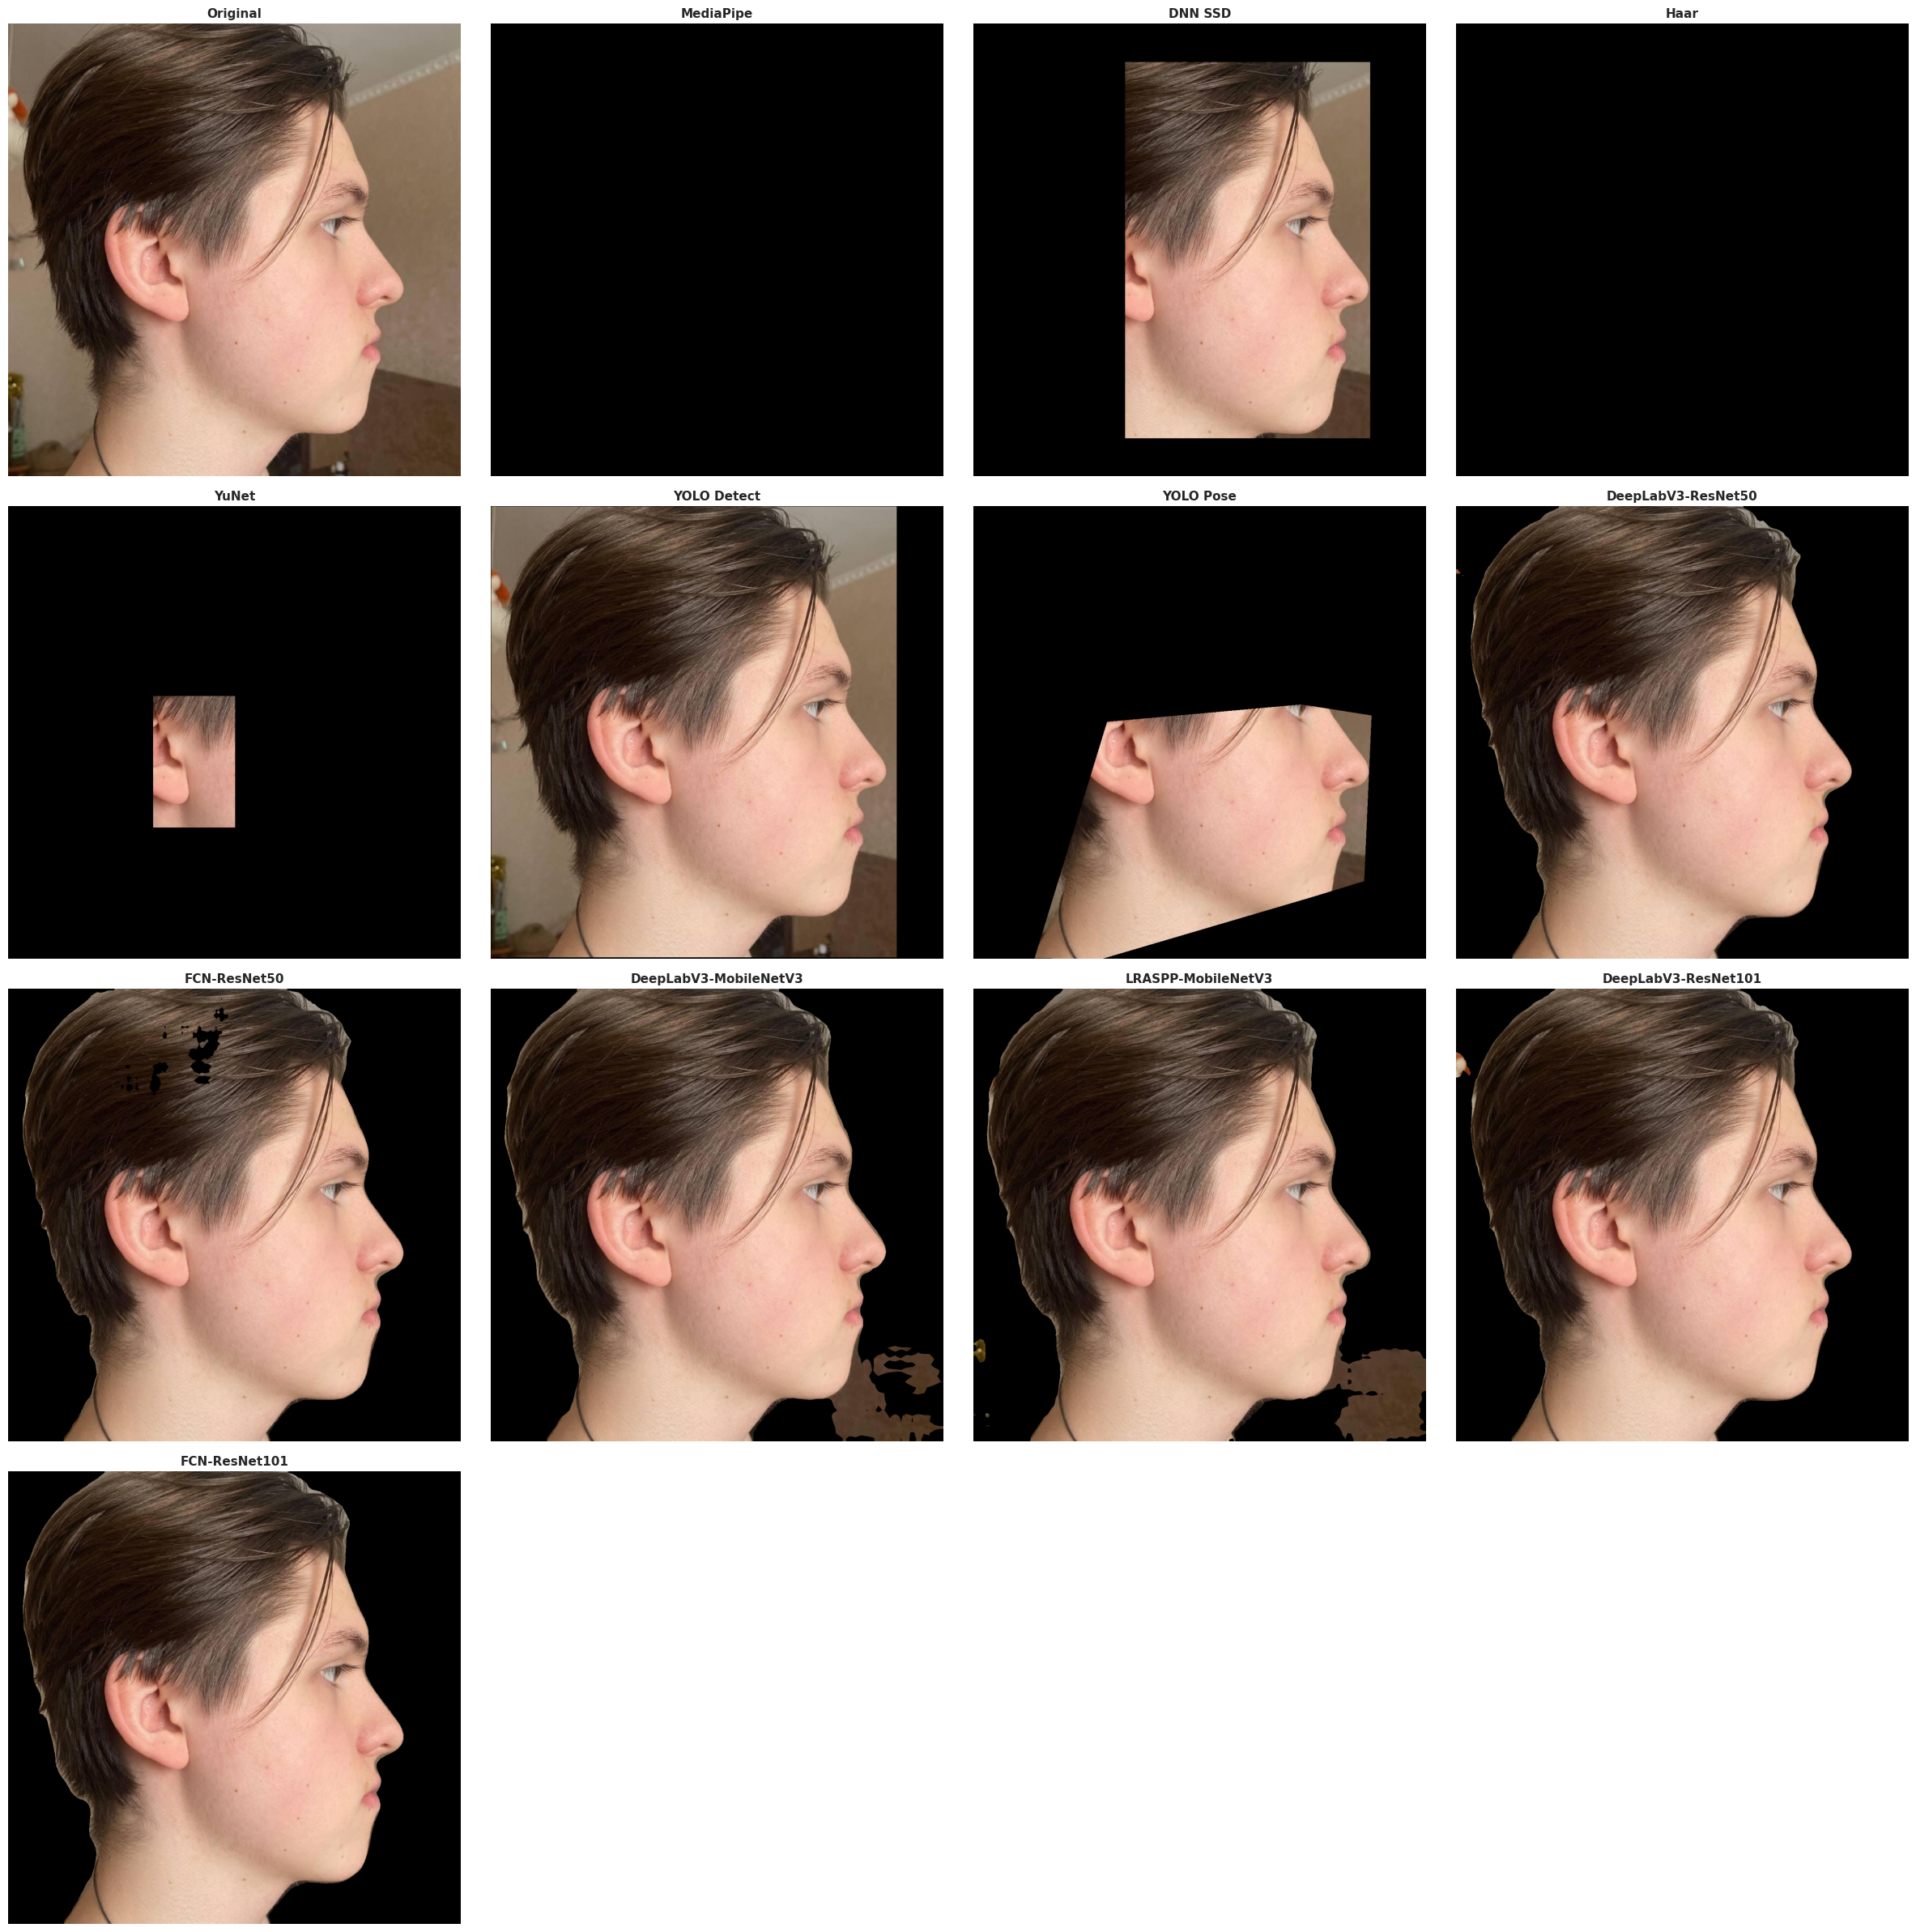


[2/3] Processing: image_332eafef_jpg.rf.13764d407ee9ed82f5794260ed824e2d.jpg


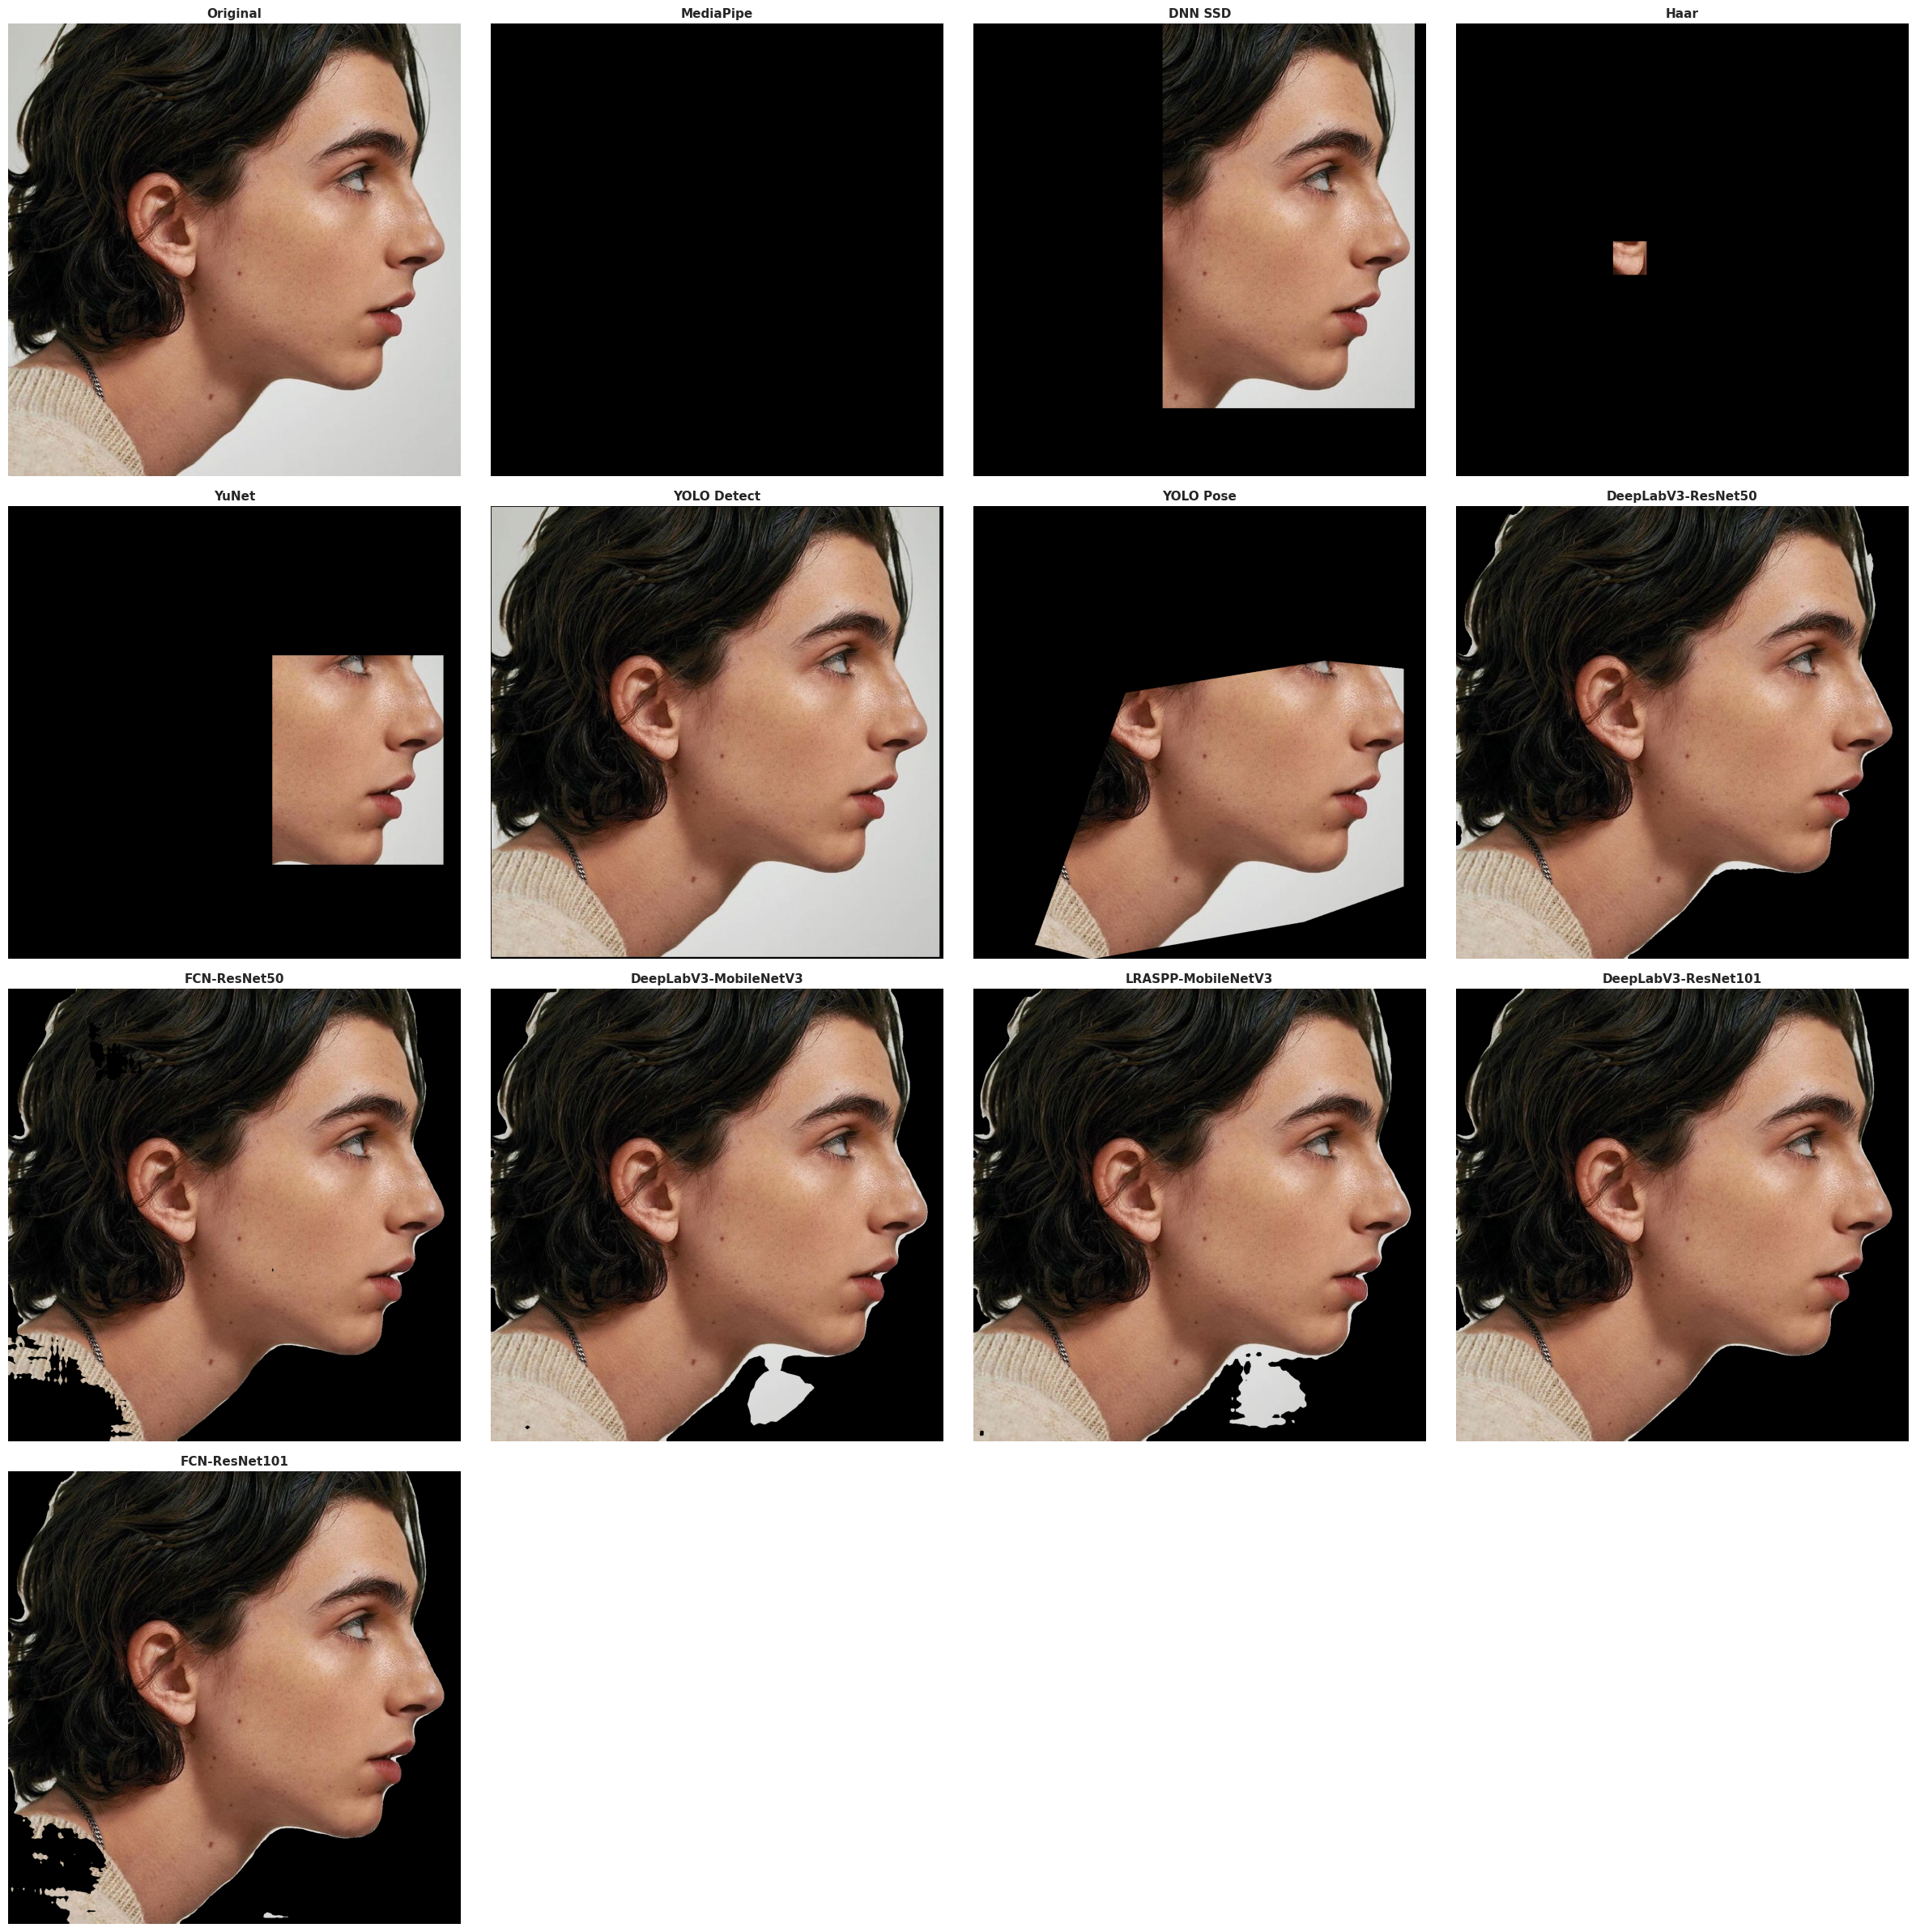


[3/3] Processing: image_8da1e84b_jpg.rf.fdd515b8c1128e4bf73c9bef4cf0dd1b.jpg


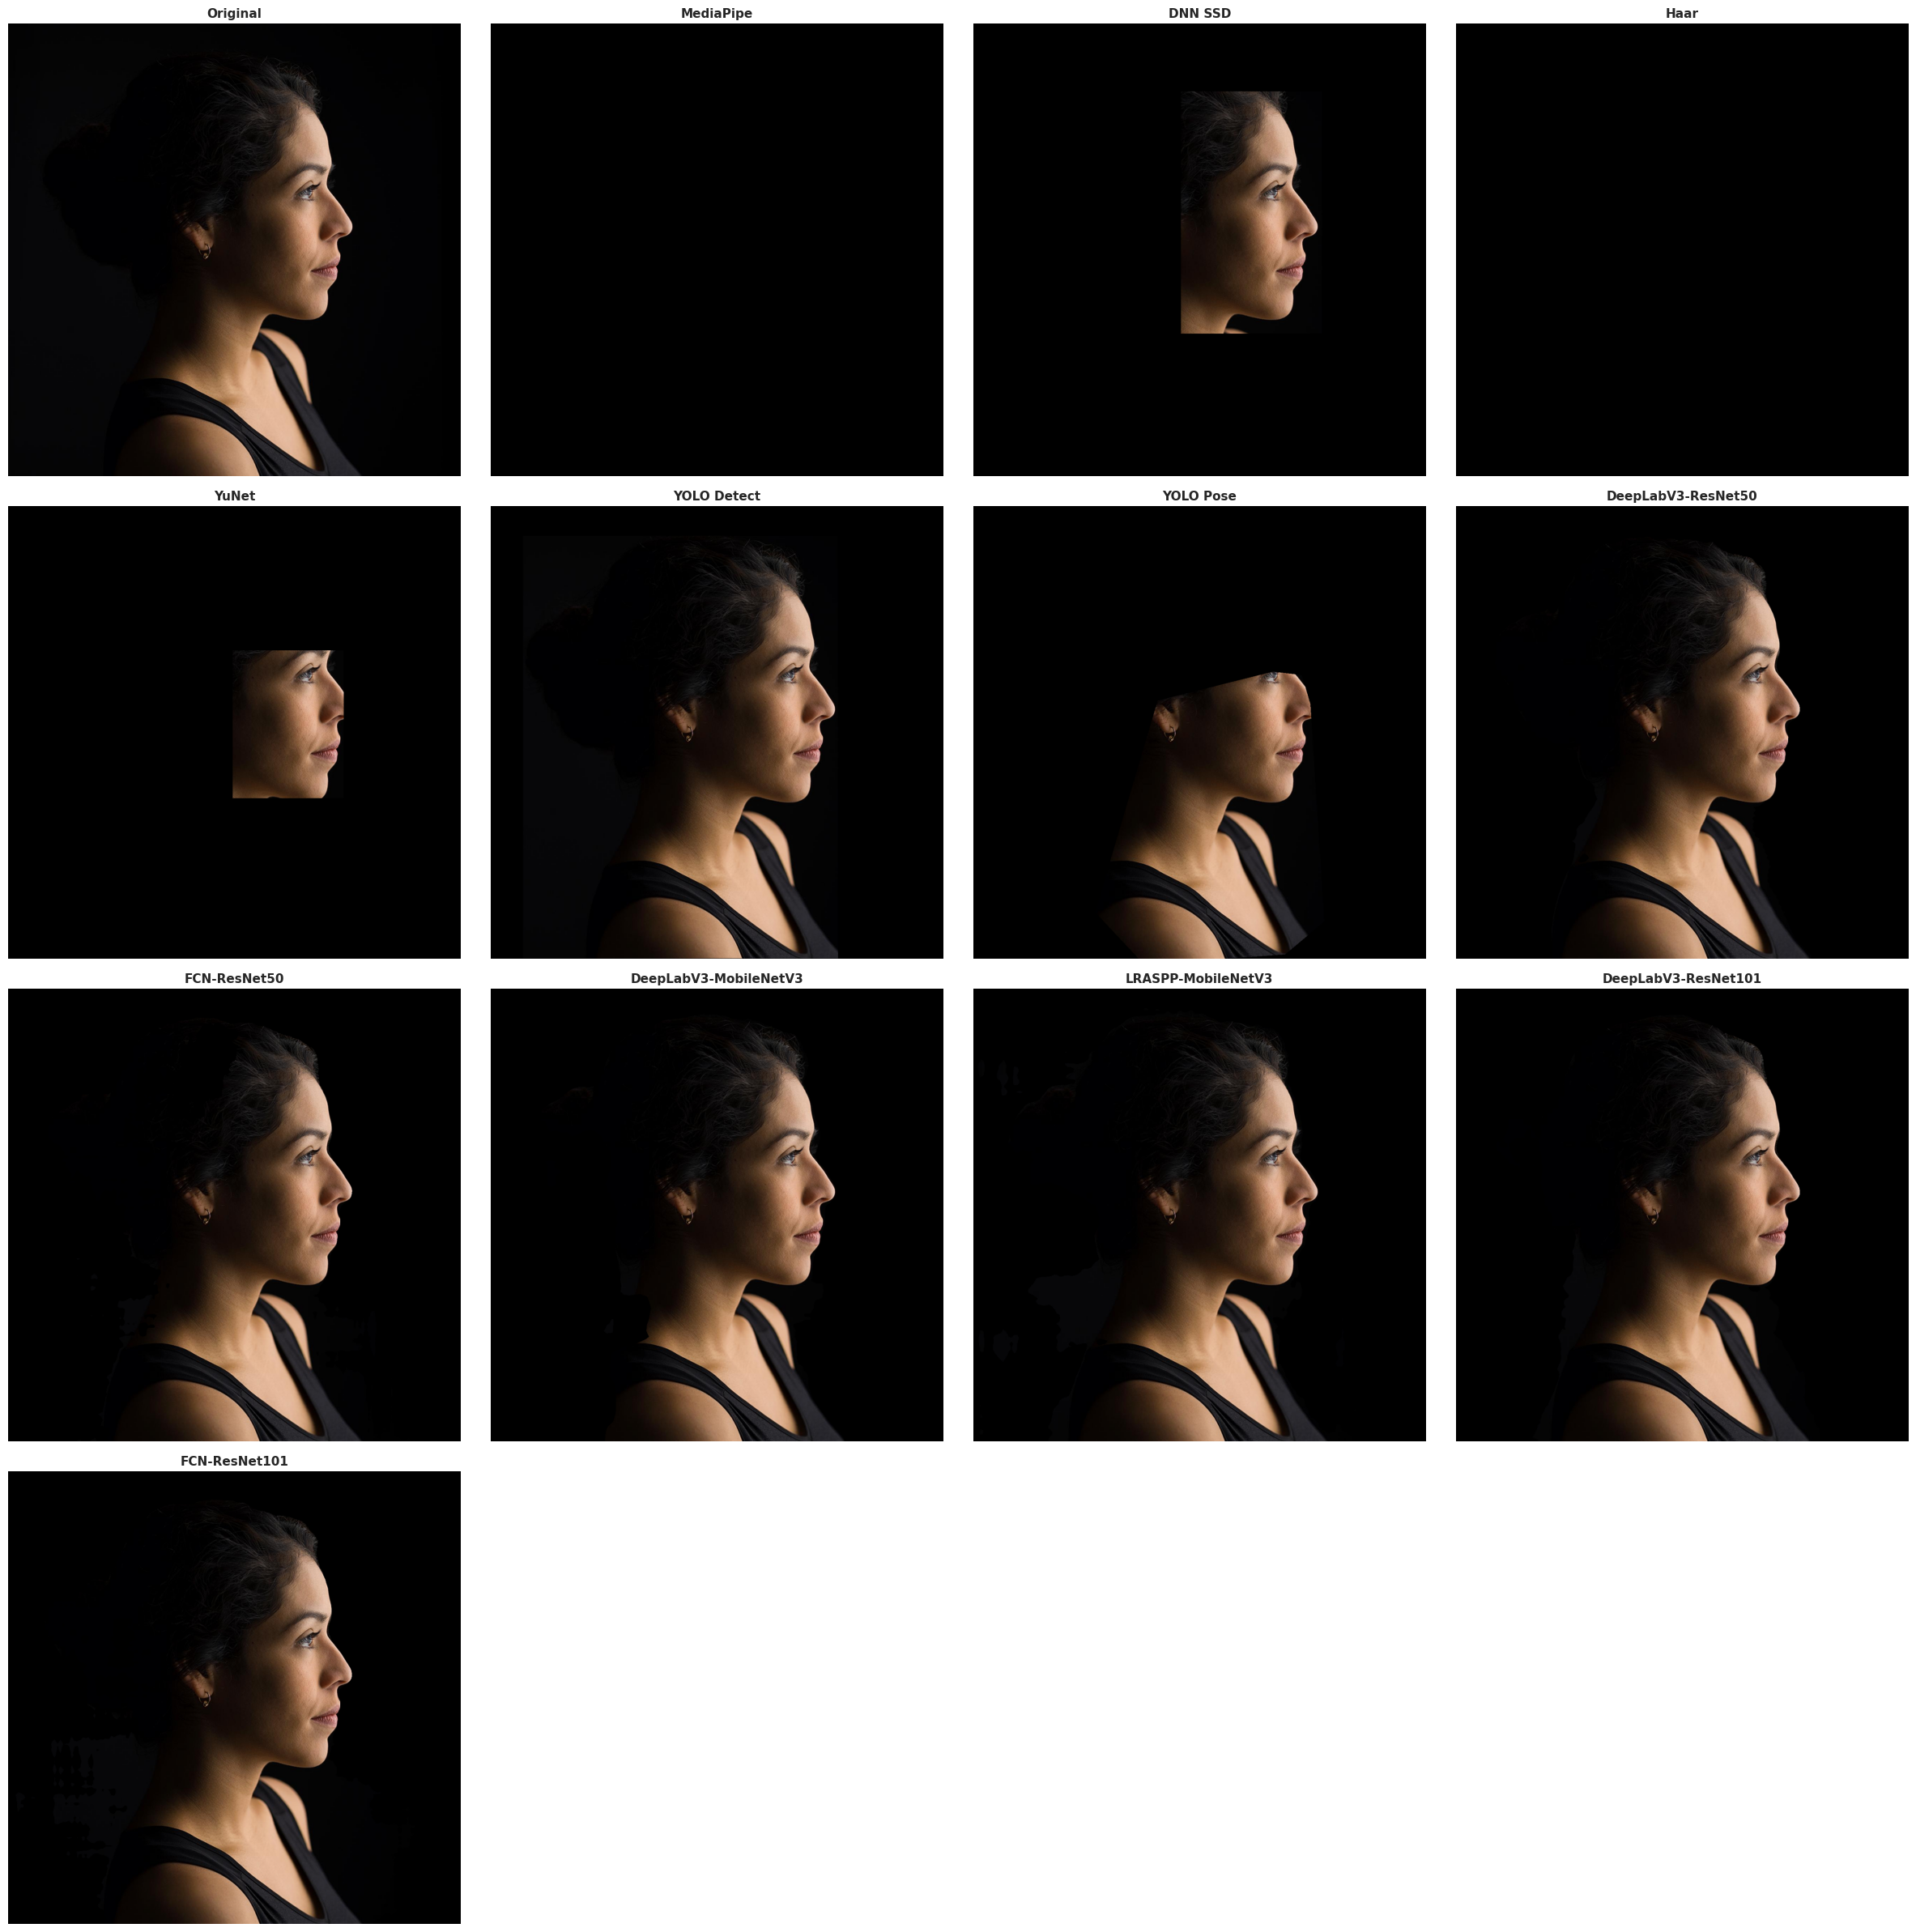


>>> STARTING BENCHMARKING (Collecting Data)...

                                   FULL MODEL PERFORMANCE REPORT                                    
                          mean    FPS     std   median      P95
Model                                                          
YOLO Pose                11.30  88.50    1.96    10.24    15.61
YOLO Detect              12.13  82.46    2.57    10.66    18.35
YOLO Class               16.67  59.98    6.03    14.19    23.87
MediaPipe                17.30  57.80    6.35    14.63    23.97
LRASPP-MobileNetV3       30.78  32.49    0.24    30.75    31.12
DNN SSD                  49.36  20.26    8.51    44.91    64.83
DeepLabV3-MobileNetV3    73.52  13.60    0.90    73.46    74.96
YuNet                   162.85   6.14   31.84   147.25   224.88
FCN-ResNet50            462.94   2.16    4.59   463.48   469.75
DeepLabV3-ResNet50      726.33   1.38    4.95   725.62   736.74
FCN-ResNet101           734.71   1.36    4.73   734.80   741.38
Haar              

/tmp/ipython-input-1995972902.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="FPS", y=summary.index, data=summary, palette="viridis", ax=ax1, orient='h')


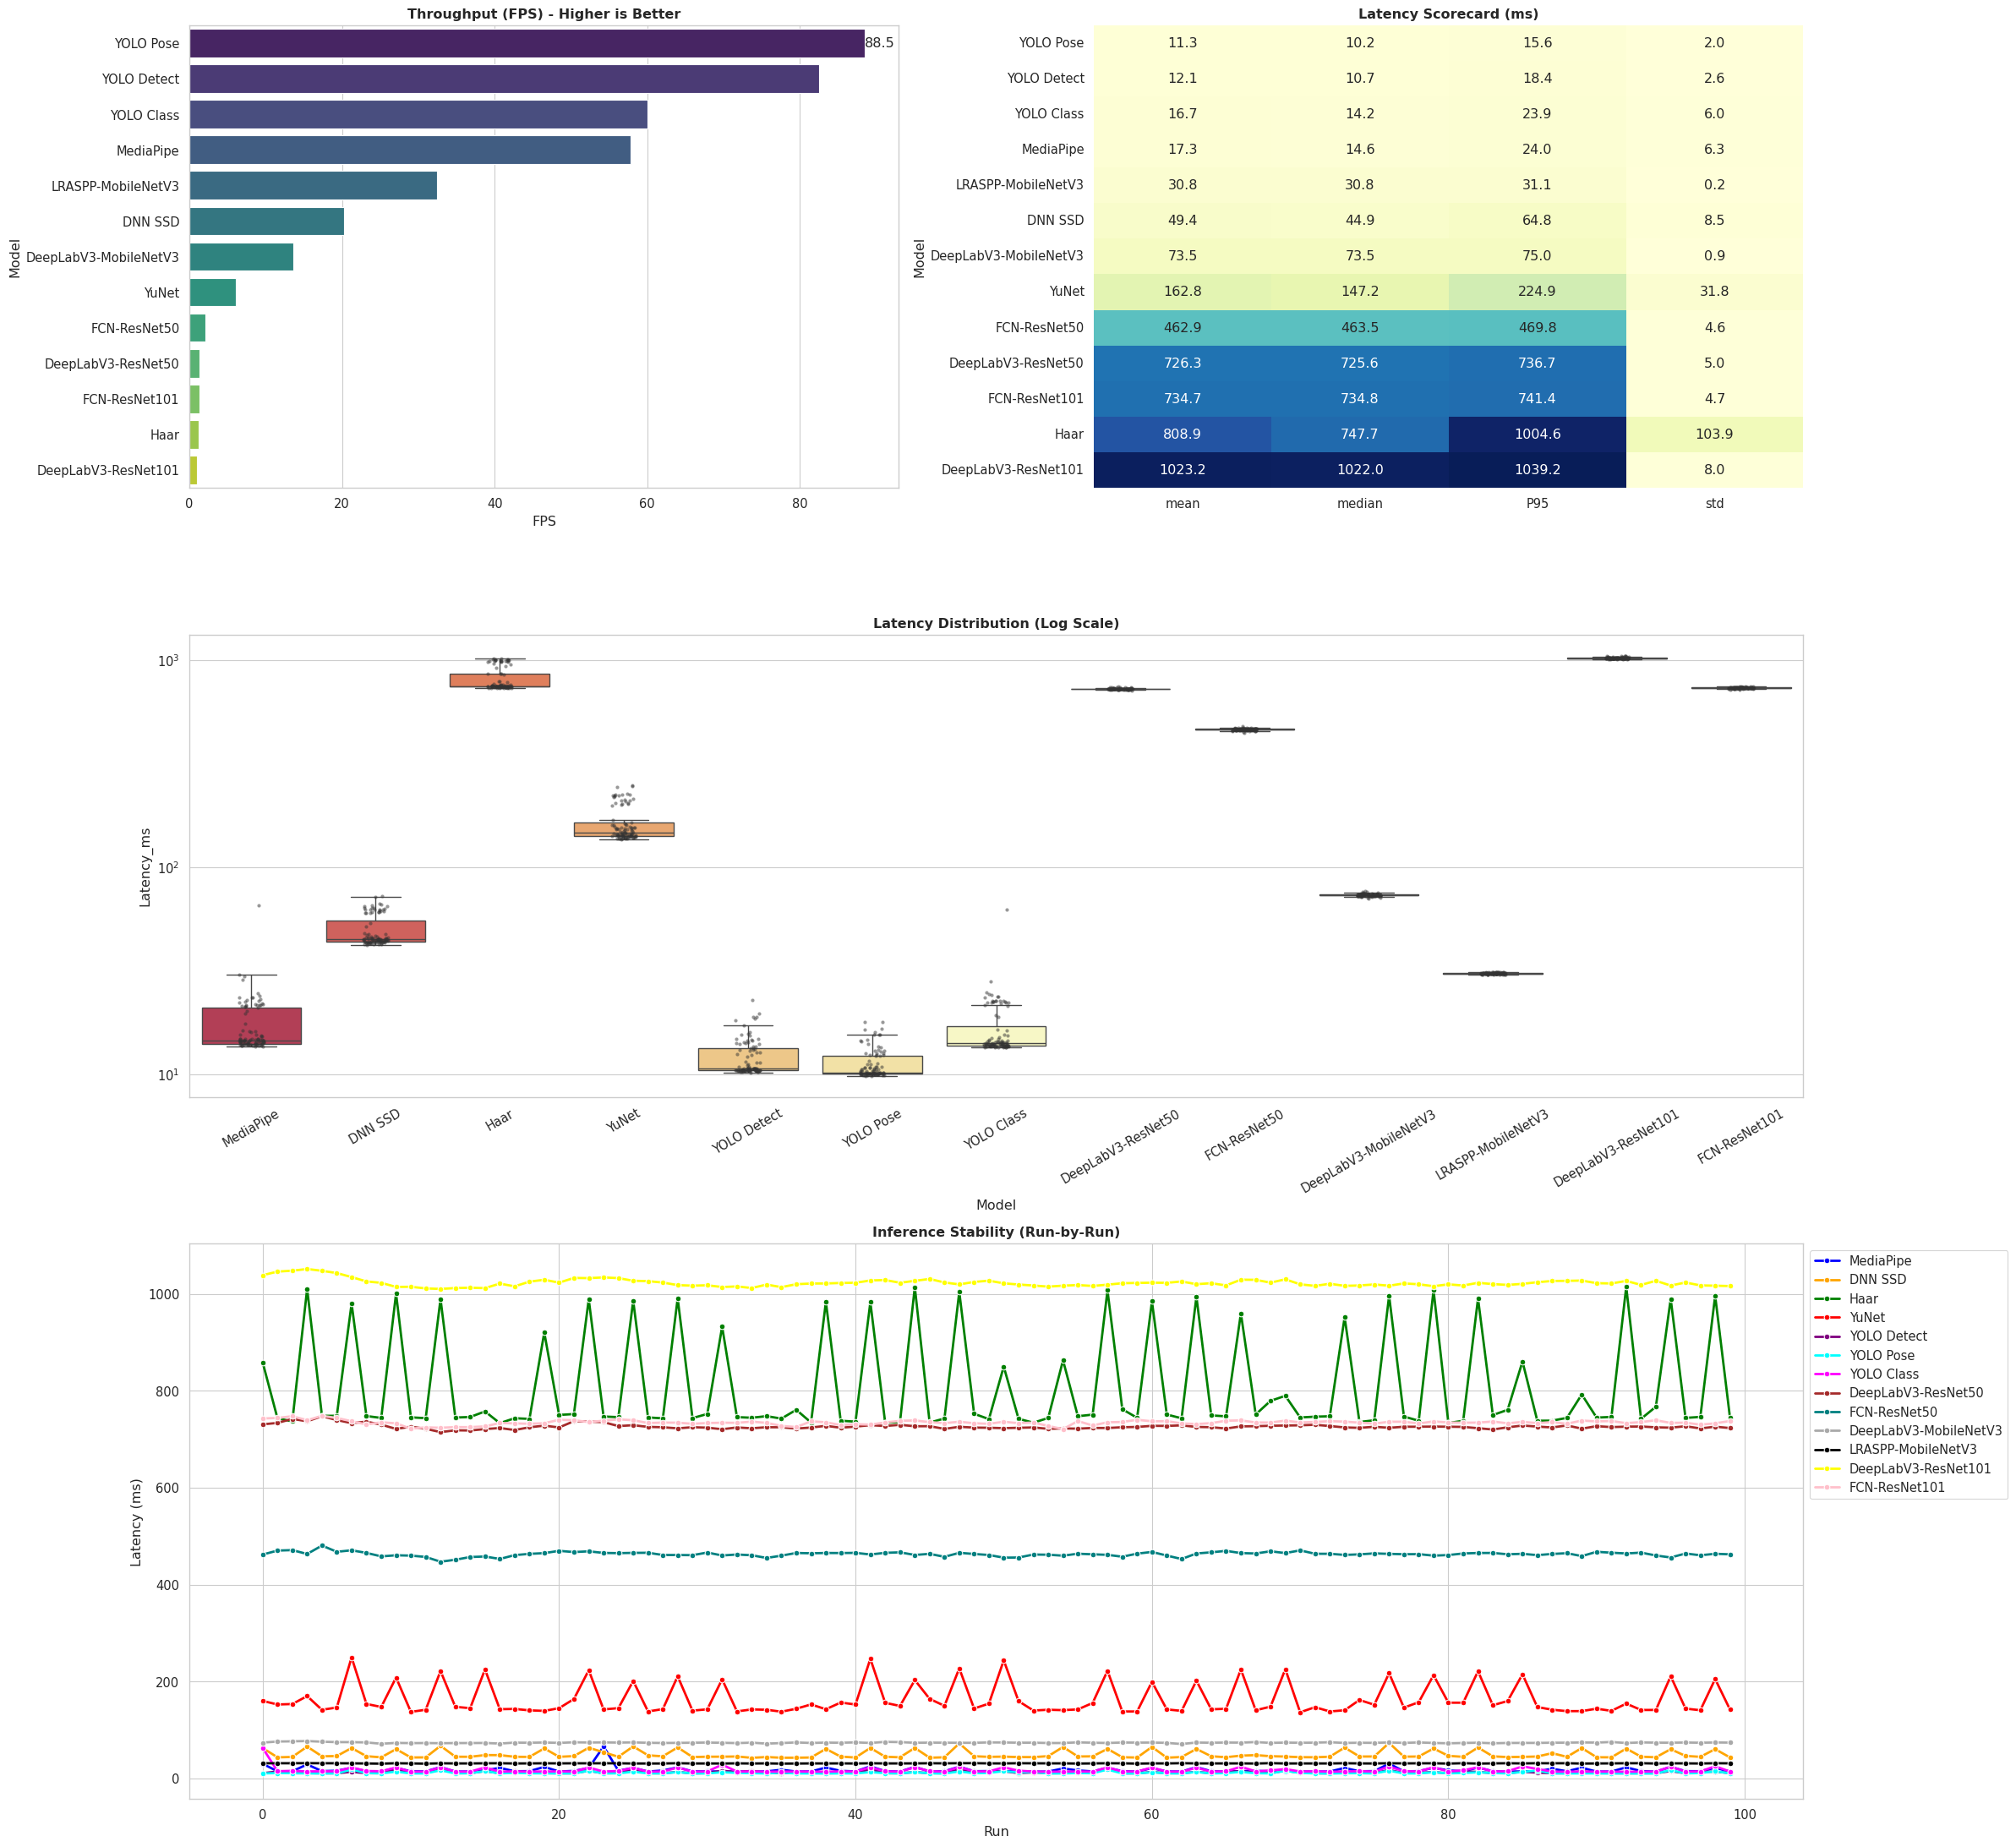

In [13]:

#

import os
import cv2
import time
import random
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks.python import vision, BaseOptions
from ultralytics import YOLO
from torchvision import models, transforms
from PIL import Image

# Force clean old files to ensure fresh downloads
!rm -f yunet.onnx deploy.prototxt res10_300x300_ssd_iter_140000.caffemodel face_landmarker.task

print(">>> Downloading fresh model files...")
!wget -q -O yunet.onnx https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/face_detection_yunet_2023mar.onnx
!wget -q -O face_landmarker.task https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_VISUAL_SAMPLES = 3
BENCHMARK_RUNS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GENERAL_EXPAND = 10
DNN_PADDING_RATIO = 0.05

print(f"Environment Ready. Device: {DEVICE}")


face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path="face_landmarker.task"),
        num_faces=1
    )
)

# --- B. OpenCV Models ---
dnn_net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")
haar = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
yunet = cv2.FaceDetectorYN.create(
    model="yunet.onnx", config="", input_size=(640, 640),
    score_threshold=0.5, nms_threshold=0.3, top_k=5000
)

# --- C. YOLO Models ---
yolo_detect = YOLO("yolov8n.pt")
yolo_pose   = YOLO("yolov8n-pose.pt")
yolo_cls    = YOLO("yolov8n-cls.pt")

# --- D. Torchvision Segmentation Models (ALL VARIANTS) ---
def load_seg(model_fn, weights):
    return model_fn(weights=weights).to(DEVICE).eval()

SEG_MODELS = {
    "DeepLabV3-ResNet50": load_seg(models.segmentation.deeplabv3_resnet50, models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT),
    "FCN-ResNet50": load_seg(models.segmentation.fcn_resnet50, models.segmentation.FCN_ResNet50_Weights.DEFAULT),
    "DeepLabV3-MobileNetV3": load_seg(models.segmentation.deeplabv3_mobilenet_v3_large, models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT),
    "LRASPP-MobileNetV3": load_seg(models.segmentation.lraspp_mobilenet_v3_large, models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT),
    "DeepLabV3-ResNet101": load_seg(models.segmentation.deeplabv3_resnet101, models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT),
    "FCN-ResNet101": load_seg(models.segmentation.fcn_resnet101, models.segmentation.FCN_ResNet101_Weights.DEFAULT),
}

torch_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"Loaded {7 + len(SEG_MODELS)} Models Total.")


all_images = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
if not all_images: raise FileNotFoundError(f"No images in {IMAGE_DIR}")
samples = random.sample(all_images, min(NUM_VISUAL_SAMPLES, len(all_images)))

print("\n>>> STARTING VISUALIZATION (Generating results for ALL models)...")

for idx, path in enumerate(samples, 1):
    print(f"\n[{idx}/{len(samples)}] Processing: {os.path.basename(path)}")
    img_bgr = cv2.imread(path)
    if img_bgr is None: continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # Store all results here
    results = {"Original": img_rgb}

    # 1. MediaPipe
    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)
    lm_result = face_landmarker.detect(mp_image)
    mask_lm = np.zeros((h, w), dtype=np.uint8)
    if lm_result.face_landmarks:
        pts = np.array([[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]], dtype=np.int32)
        cv2.fillConvexPoly(mask_lm, cv2.convexHull(pts), 255)
    results["MediaPipe"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)

    # 2. SSD
    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0))
    dnn_net.setInput(blob)
    detections = dnn_net.forward()
    mask_dnn = np.zeros((h, w), dtype=np.uint8)
    if detections.shape[2] > 0:
        for i in range(detections.shape[2]):
            if detections[0, 0, i, 2] > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                x1, y1, x2, y2 = box.astype(int)
                bw, bh = x2-x1, y2-y1
                pad_w, pad_h = int(bw*DNN_PADDING_RATIO), int(bh*DNN_PADDING_RATIO)
                mask_dnn[max(0, y1-pad_h):min(h, y2+pad_h), max(0, x1-pad_w):min(w, x2+pad_w)] = 255
                break
    results["DNN SSD"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)

    # 3. Haar
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    mask_haar = np.zeros((h, w), dtype=np.uint8)
    if len(faces):
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y+fh, x:x+fw] = 255
    results["Haar"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)

    # 4. YuNet
    yunet.setInputSize((w, h))
    _, faces_yu = yunet.detect(img_bgr)
    mask_yu = np.zeros((h, w), dtype=np.uint8)
    if faces_yu is not None and len(faces_yu) > 0:
        face = faces_yu[0]
        x, y, bw, bh = face[0:4].astype(int)
        mask_yu[y:y+bh, x:x+bw] = 255
    results["YuNet"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_yu)

    # 5. YOLO Detect
    r_det = yolo_detect(img_rgb, conf=0.4, verbose=False)[0]
    mask_det = np.zeros((h, w), dtype=np.uint8)
    if r_det.boxes and len(r_det.boxes) > 0:
        b = r_det.boxes.xyxy.cpu().numpy()[0].astype(int)
        mask_det[b[1]:b[3], b[0]:b[2]] = 255
    results["YOLO Detect"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_det)

    # 6. YOLO Pose
    r_pose = yolo_pose(img_rgb, conf=0.4, verbose=False)[0]
    mask_pose = np.zeros((h, w), dtype=np.uint8)
    if r_pose.keypoints is not None and len(r_pose.keypoints.xy) > 0:
        kps = r_pose.keypoints.xy.cpu().numpy()[0].astype(int)
        cv2.fillConvexPoly(mask_pose, cv2.convexHull(kps), 255)
    results["YOLO Pose"] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_pose)

    # 7. ALL Segmentation Models
    input_tensor = torch_preprocess(img_rgb).unsqueeze(0).to(DEVICE)
    for name, model in SEG_MODELS.items():
        with torch.no_grad(): out = model(input_tensor)["out"]
        pred = out[0].argmax(0).cpu().numpy()
        mask_seg = cv2.resize(((pred == 15).astype(np.uint8) * 255), (w, h), interpolation=cv2.INTER_NEAREST)
        results[name] = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_seg)

    # Plotting Grid (4 columns)
    cols = 4
    rows = (len(results) + cols - 1) // cols
    plt.figure(figsize=(24, 6 * rows))
    for i, (name, img) in enumerate(results.items(), 1):
        plt.subplot(rows, cols, i)
        plt.title(name, fontsize=11, fontweight='bold')
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


print("\n>>> STARTING BENCHMARKING (Collecting Data)...")

bench_img_bgr = cv2.imread(samples[0])
bench_img_rgb = cv2.cvtColor(bench_img_bgr, cv2.COLOR_BGR2RGB)
h, w, _ = bench_img_rgb.shape

# Inputs
mp_input = mp.Image(mp.ImageFormat.SRGB, bench_img_rgb)
blob_input = cv2.dnn.blobFromImage(bench_img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0))
torch_input = torch_preprocess(bench_img_rgb).unsqueeze(0).to(DEVICE)

data = []

# Warmup
with torch.no_grad():
    for _ in range(2):
        for m in SEG_MODELS.values(): _ = m(torch_input)
        yolo_detect(bench_img_rgb, verbose=False)

# Loop
for i in range(BENCHMARK_RUNS):
    # Detectors
    t0=time.perf_counter(); face_landmarker.detect(mp_input); data.append({"Model":"MediaPipe","Run":i,"Latency_ms":(time.perf_counter()-t0)*1000})

    t0=time.perf_counter(); dnn_net.setInput(blob_input); dnn_net.forward(); data.append({"Model":"DNN SSD","Run":i,"Latency_ms":(time.perf_counter()-t0)*1000})

    gray_b=cv2.cvtColor(bench_img_bgr,cv2.COLOR_BGR2GRAY)
    t0=time.perf_counter(); haar.detectMultiScale(gray_b,1.1,5); data.append({"Model":"Haar","Run":i,"Latency_ms":(time.perf_counter()-t0)*1000})

    yunet.setInputSize((w, h))
    t0=time.perf_counter(); yunet.detect(bench_img_bgr); data.append({"Model":"YuNet","Run":i,"Latency_ms":(time.perf_counter()-t0)*1000})

    t0=time.perf_counter(); yolo_detect(bench_img_rgb,verbose=False); data.append({"Model":"YOLO Detect","Run":i,"Latency_ms":(time.perf_counter()-t0)*1000})
    t0=time.perf_counter(); yolo_pose(bench_img_rgb,verbose=False); data.append({"Model":"YOLO Pose","Run":i,"Latency_ms":(time.perf_counter()-t0)*1000})
    t0=time.perf_counter(); yolo_cls(bench_img_rgb,verbose=False); data.append({"Model":"YOLO Class","Run":i,"Latency_ms":(time.perf_counter()-t0)*1000})

    # Segmentation (All Variants)
    if DEVICE=="cuda": torch.cuda.synchronize()
    for name, model in SEG_MODELS.items():
        t0=time.perf_counter()
        with torch.no_grad(): _=model(torch_input)["out"]
        if DEVICE=="cuda": torch.cuda.synchronize()
        data.append({"Model":name, "Run":i, "Latency_ms":(time.perf_counter()-t0)*1000})

df = pd.DataFrame(data)


summary = df.groupby('Model')['Latency_ms'].agg(['mean','median','std','min','max']).sort_values('mean')
summary['FPS'] = 1000.0 / summary['mean']
summary['P95'] = df.groupby('Model')['Latency_ms'].quantile(0.95)
summary = summary.round(2)

print("\n" + "="*100)
print(f"{'FULL MODEL PERFORMANCE REPORT':^100}")
print("="*100)
print(summary[['mean','FPS','std','median','P95']].to_string())
print("="*100 + "\n")

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
fig = plt.figure(figsize=(24, 22))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.2])

# 1. Bar Plot (FPS)
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(x="FPS", y=summary.index, data=summary, palette="viridis", ax=ax1, orient='h')
ax1.set_title("Throughput (FPS) - Higher is Better", fontweight='bold')
ax1.bar_label(ax1.containers[0], fmt='%.1f')

# 2. Heatmap
ax2 = fig.add_subplot(gs[0, 1])
hm_data = summary[['mean', 'median', 'P95', 'std']].copy()
sns.heatmap(hm_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False, ax=ax2)
ax2.set_title("Latency Scorecard (ms)", fontweight='bold')

# 3. Box Plot (Log Scale for visibility of fast vs slow models)
ax3 = fig.add_subplot(gs[1, :])
sns.boxplot(x="Model", y="Latency_ms", data=df, hue="Model", palette="Spectral", ax=ax3, showfliers=False, legend=False)
sns.stripplot(x="Model", y="Latency_ms", data=df, color=".2", size=3, alpha=0.5, ax=ax3)
ax3.set_yscale("log")
ax3.set_title("Latency Distribution (Log Scale)", fontweight='bold')
ax3.tick_params(axis='x', rotation=30)


ax4 = fig.add_subplot(gs[2, :])

# Define the exact 13 colors
custom_colors = [
    "blue", "orange", "green", "red", "purple", "cyan", "magenta",
    "brown", "teal", "darkgray", "black", "yellow", "pink"
]

sns.lineplot(
    x="Run",
    y="Latency_ms",
    hue="Model",
    data=df,
    palette=custom_colors,
    marker="o",
    linewidth=2,
    ax=ax4
)

ax4.set_title("Inference Stability (Run-by-Run)", fontweight='bold')
ax4.set_ylabel("Latency (ms)")
ax4.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', ncol=1, frameon=True)

plt.tight_layout()
plt.show()

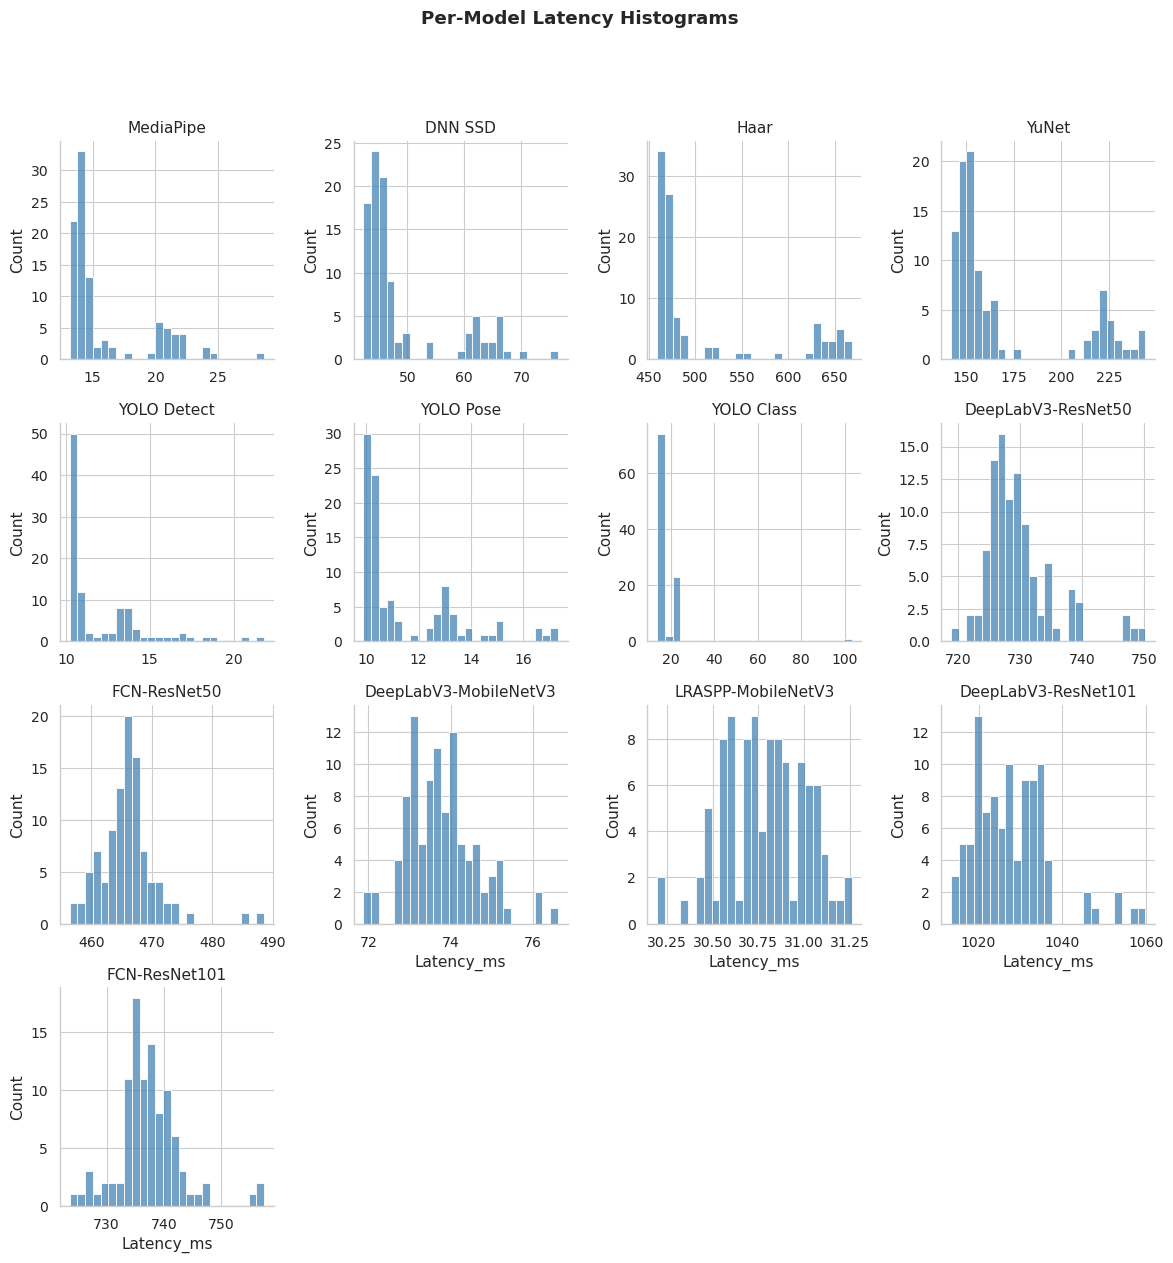

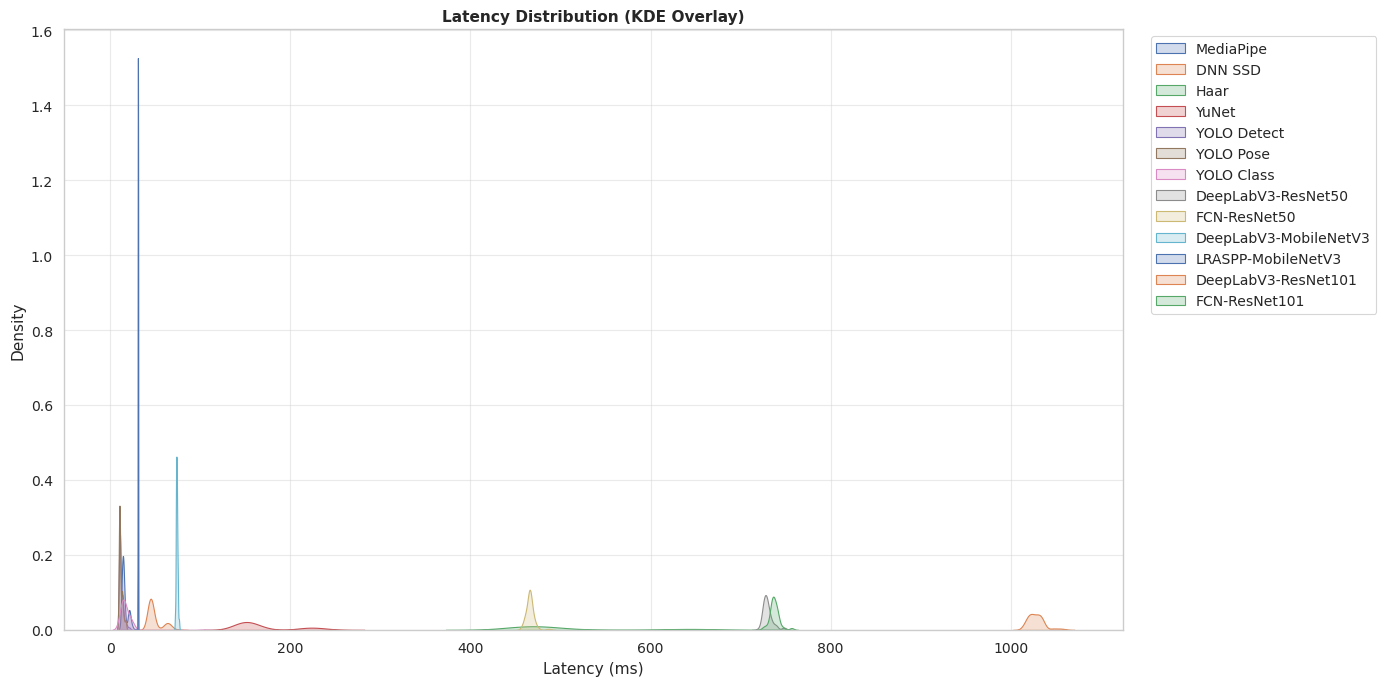

/tmp/ipython-input-4029129400.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


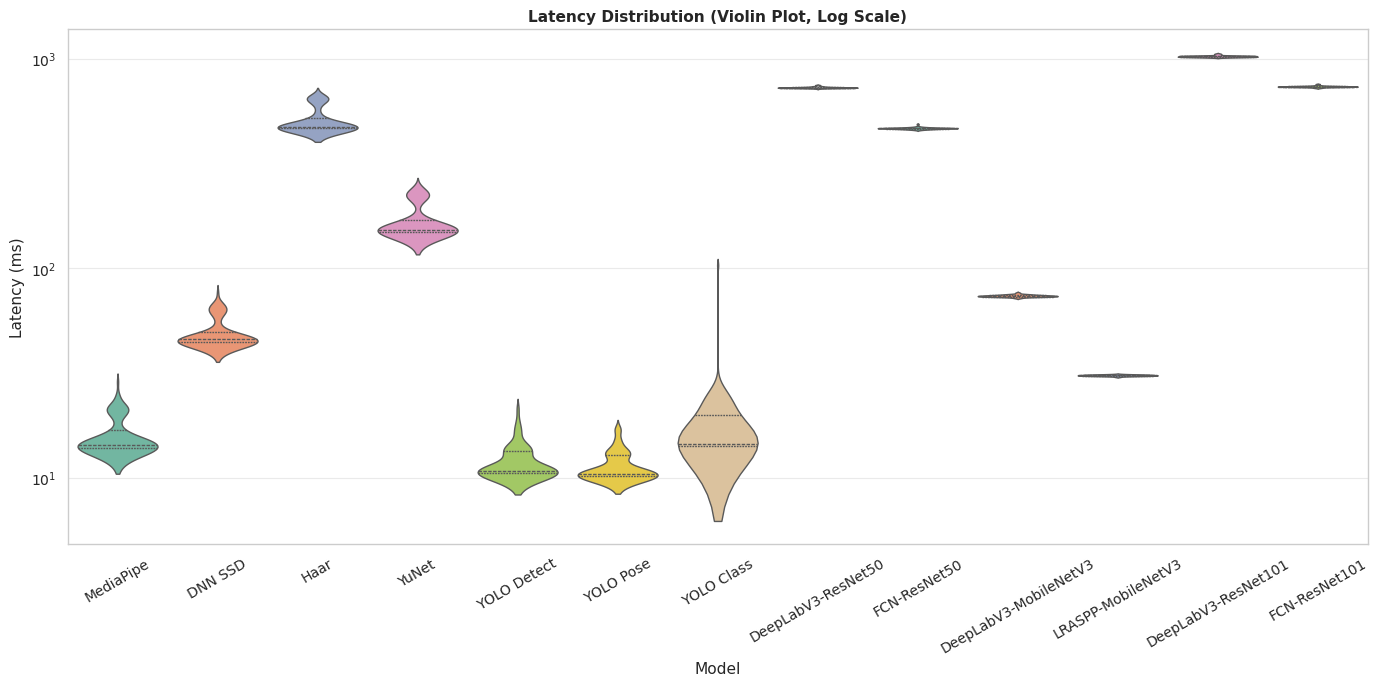

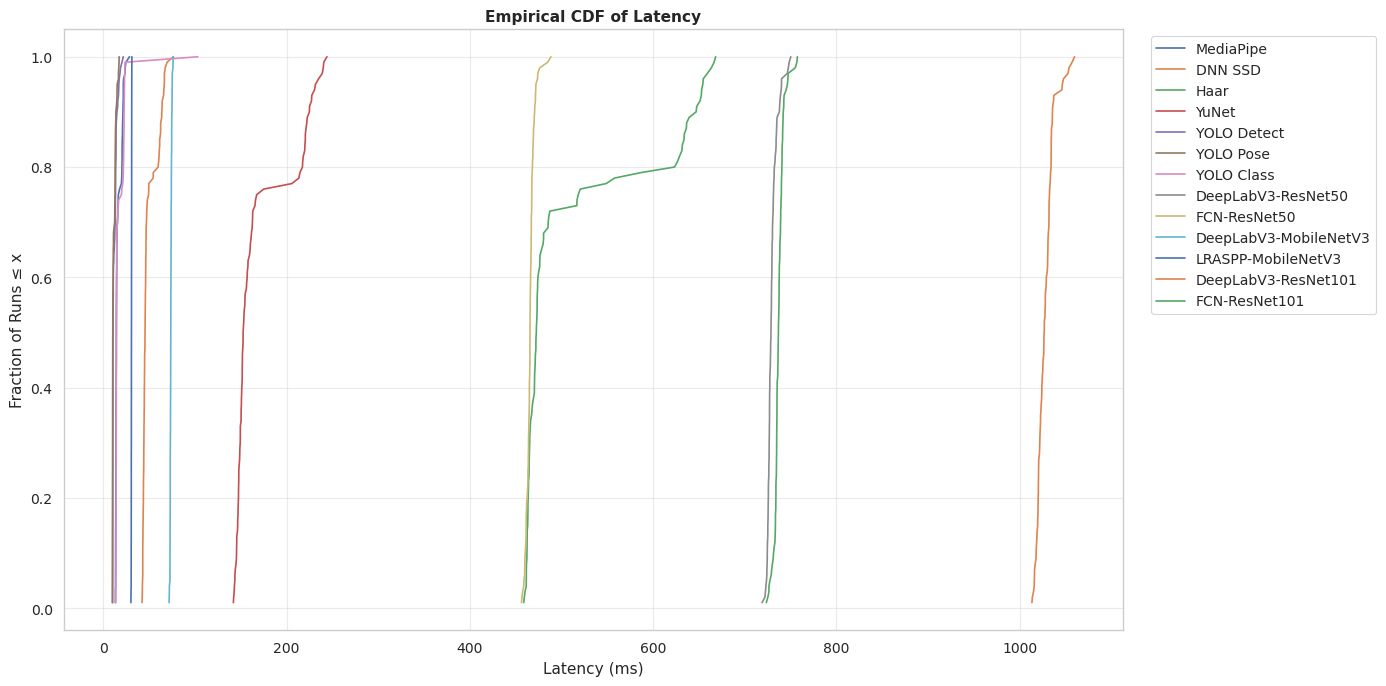

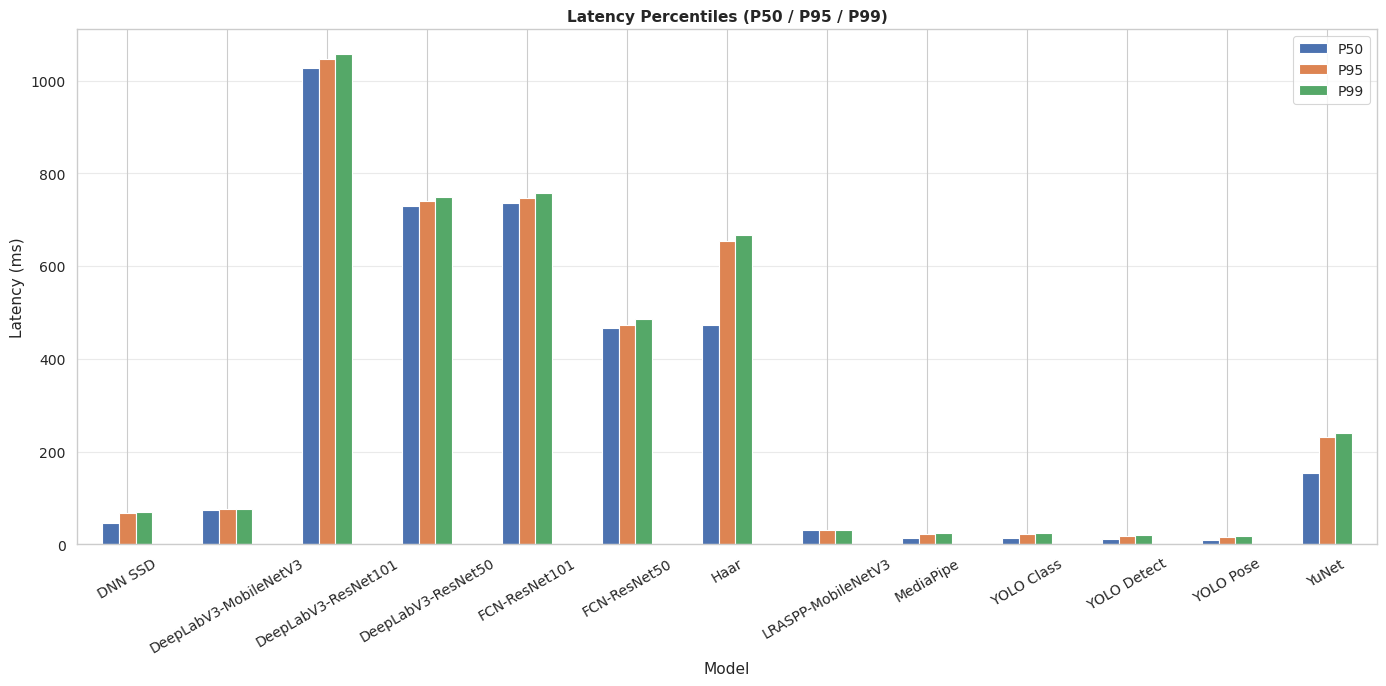

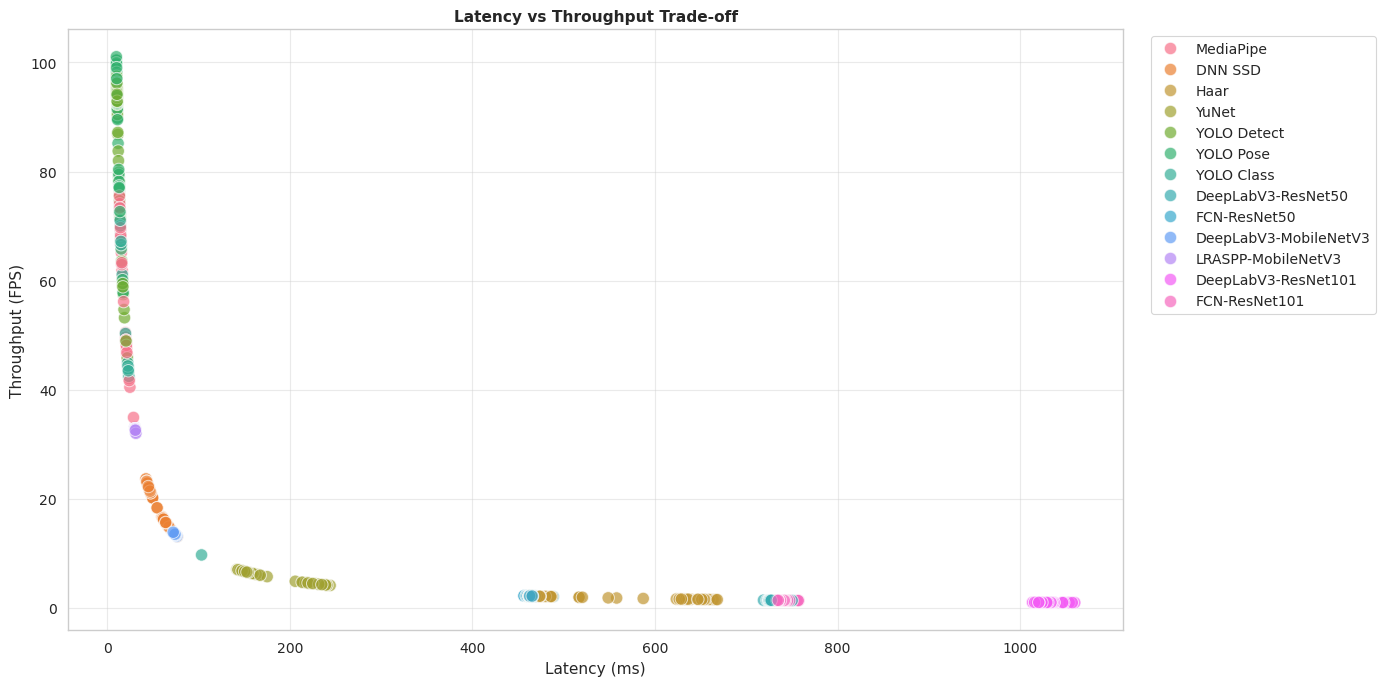

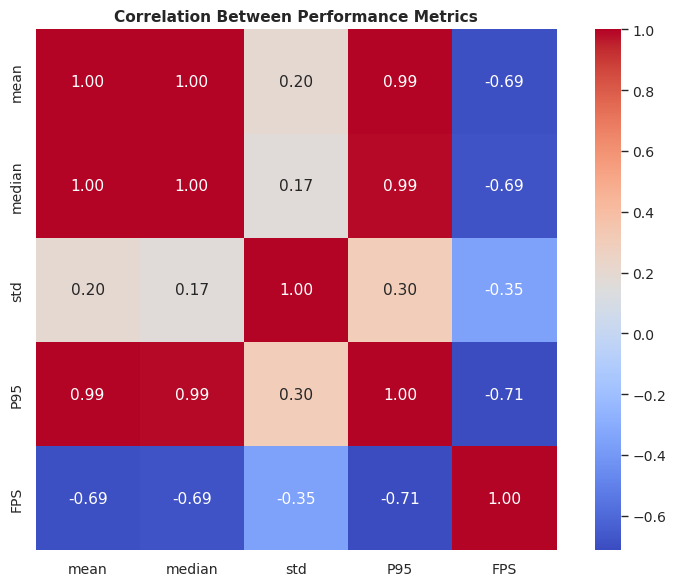

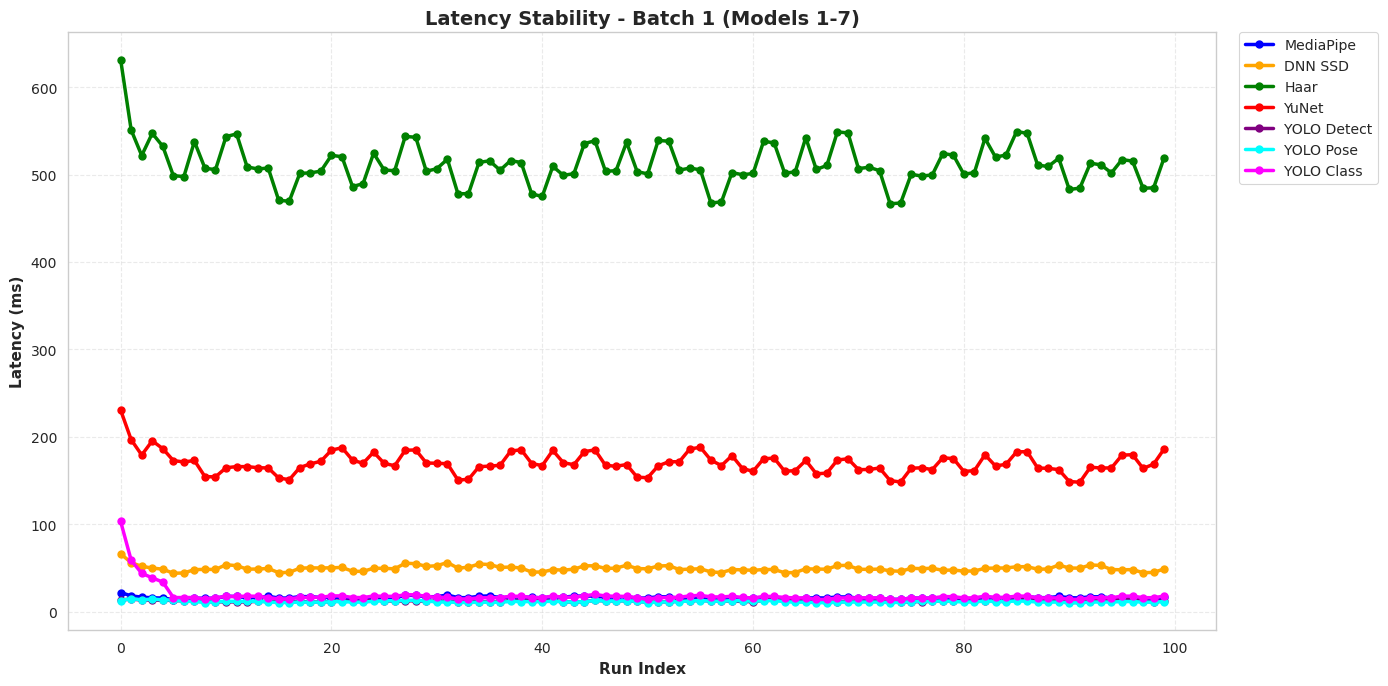

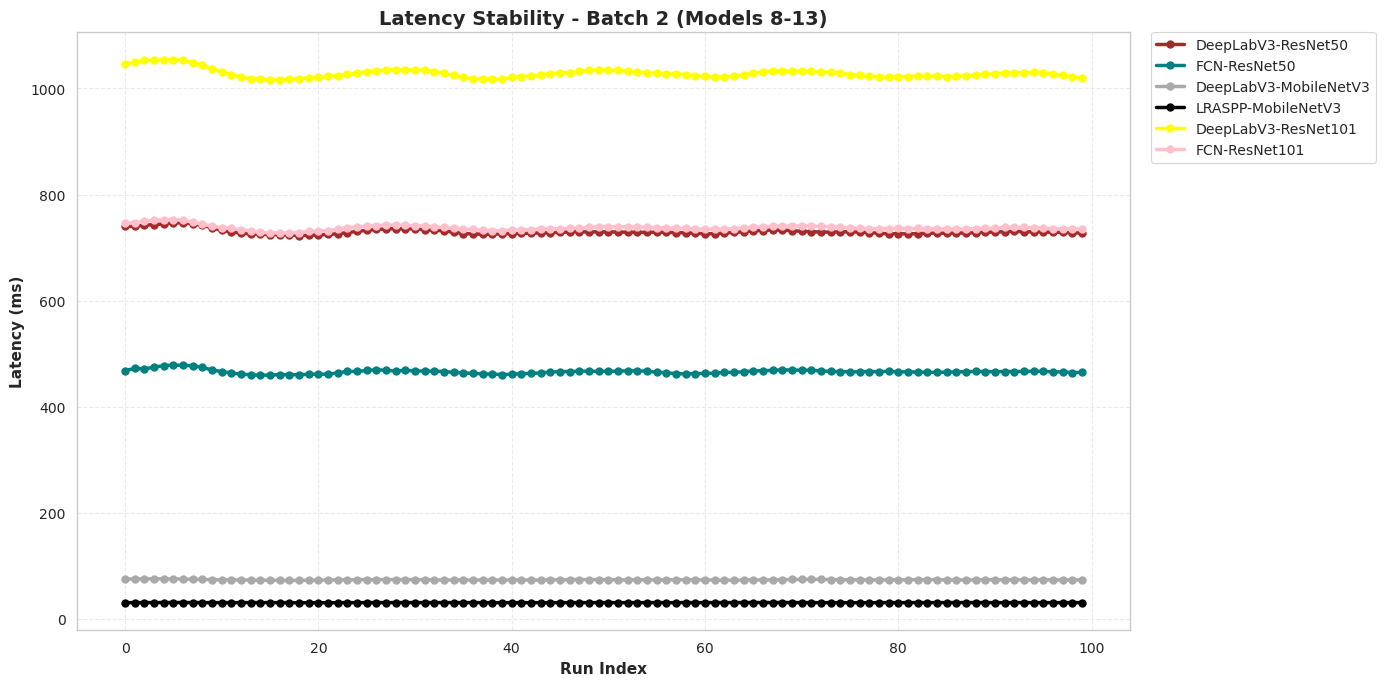

In [12]:
from statsmodels.distributions.empirical_distribution import ECDF

# Ensure seaborn style consistency
sns.set_theme(style="whitegrid", context="paper", font_scale=1.15)


g = sns.FacetGrid(
    df,
    col="Model",
    col_wrap=4,
    height=3,
    sharex=False,
    sharey=False
)
g.map_dataframe(
    sns.histplot,
    x="Latency_ms",
    bins=25,
    kde=False,
    color="steelblue"
)
g.set_titles("{col_name}")
g.fig.suptitle("Per-Model Latency Histograms", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()


plt.figure(figsize=(14,7))
for model in df["Model"].unique():
    sns.kdeplot(
        df[df["Model"] == model]["Latency_ms"],
        label=model,
        fill=True,
        alpha=0.25
    )
plt.title("Latency Distribution (KDE Overlay)", fontweight="bold")
plt.xlabel("Latency (ms)")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


plt.figure(figsize=(14,7))
sns.violinplot(
    data=df,
    x="Model",
    y="Latency_ms",
    inner="quartile",
    palette="Set2"
)
plt.yscale("log")
plt.title("Latency Distribution (Violin Plot, Log Scale)", fontweight="bold")
plt.ylabel("Latency (ms)")
plt.xticks(rotation=30)
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()


plt.figure(figsize=(14,7))
for model in df["Model"].unique():
    vals = df[df["Model"] == model]["Latency_ms"].values
    ecdf = ECDF(vals)
    plt.plot(ecdf.x, ecdf.y, label=model)
plt.xlabel("Latency (ms)")
plt.ylabel("Fraction of Runs ≤ x")
plt.title("Empirical CDF of Latency", fontweight="bold")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


percentile_df = pd.DataFrame({
    "P50": df.groupby("Model")["Latency_ms"].median(),
    "P95": df.groupby("Model")["Latency_ms"].quantile(0.95),
    "P99": df.groupby("Model")["Latency_ms"].quantile(0.99),
}).reset_index()

percentile_df.set_index("Model").plot(
    kind="bar",
    figsize=(14,7)
)
plt.title("Latency Percentiles (P50 / P95 / P99)", fontweight="bold")
plt.ylabel("Latency (ms)")
plt.xticks(rotation=30)
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()


df["Throughput_FPS"] = 1000.0 / df["Latency_ms"]

plt.figure(figsize=(14,7))
sns.scatterplot(
    data=df,
    x="Latency_ms",
    y="Throughput_FPS",
    hue="Model",
    s=80,
    alpha=0.7
)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (FPS)")
plt.title("Latency vs Throughput Trade-off", fontweight="bold")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


corr_data = summary[["mean", "median", "std", "P95", "FPS"]]
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_data.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    square=True
)
plt.title("Correlation Between Performance Metrics", fontweight="bold")
plt.tight_layout()
plt.show()



# 1. Distiguishable Colours
colors_list = [
    "blue", "orange", "green", "red", "purple", "cyan", "magenta",
    "brown", "teal", "darkgray", "black", "yellow", "pink"
]

# 2. Split models into two batches
unique_models = df["Model"].unique()
split_idx = 7  # Split point
batch_1 = unique_models[:split_idx]
batch_2 = unique_models[split_idx:]

batches = [
    (batch_1, "Latency Stability - Batch 1 (Models 1-7)"),
    (batch_2, "Latency Stability - Batch 2 (Models 8-13)")
]

# 3. Plot loop
color_idx = 0  # To keep track of colors across both graphs

for models_in_batch, title in batches:
    plt.figure(figsize=(14, 7))

    for model in models_in_batch:
        # Get data for this model
        tmp = df[df["Model"] == model].sort_values("Run")

        # Pick consistent color from your list
        c = colors_list[color_idx % len(colors_list)]
        color_idx += 1

        plt.plot(
            tmp["Run"],
            tmp["Latency_ms"].rolling(window=5, min_periods=1).mean(),
            label=model,
            linewidth=2.5,
            color=c,
            marker='o',  # Added markers to see data points better
            markersize=5
        )

    plt.xlabel("Run Index", fontweight='bold')
    plt.ylabel("Latency (ms)", fontweight='bold')
    plt.title(title, fontweight="bold", fontsize=14)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()
